In [198]:
import numpy as np
import pandas as pd
import patsy
import itertools

from sklearn.linear_model import (Ridge, Lasso, ElasticNet, LinearRegression, RidgeCV, 
                     LassoCV, ElasticNetCV,  SGDRegressor, SGDClassifier)

from sklearn.grid_search import GridSearchCV, RandomizedSearchCV

from sklearn.cross_validation import cross_val_score
from sklearn.metrics import mean_squared_error

from sklearn import grid_search, datasets

import datetime
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima_model import ARMA
from sklearn.metrics import r2_score

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

<center>
<h1> <b> Problem statement </b> <h1>
<h2> <center>  Is there a relationship between PGE electrical usage  and solar power accumulation 
in CA bet 2012 - 2016?  </h2>
</center>

Context: In CA, California Public Utilities Commision (CPUC) regulates California’s three large investor owned electric utilities – Pacific Gas and Electric (PG&E), Southern California Edison (SCE), and San Diego Gas and Electric (SDG&E). This study focuses on just PGE, so it is therefore incomplete.
<br>
As we see some of the numbers below, PG&E only covers a portions of the state's area.
<br>
This means that only 818/2667 = 0.3067 ZIP codes have solar power in CA! The PGE number depends on the sampling rate. Since ZIP codes are propotional to population, PG&E covers only about 30% of CA.
<br>
I have not found yet another study of PG&E electical usage vs solar power generation, so I cannot compare these results with any prior work.


<center>
<h2> 1. Load in Q1 - Q2 for 2012 -  2016 electric data from PG&E  </h2>
</center>

In [199]:
#2016, Q1-Q2
pge_q1 = pd.read_csv("PGE_2016_Q1_ElectricUsageByZip.csv")
pge_q2 = pd.read_csv("PGE_2016_Q2_ElectricUsageByZip.csv")

#2015, Q1-Q2
pge_q3 = pd.read_csv("PGE_2015_Q1_ElectricUsageByZip.csv")
pge_q4 = pd.read_csv("PGE_2015_Q2_ElectricUsageByZip.csv")

# 2014
pge_q5 = pd.read_csv("PGE_2014_Q1_ElectricUsageByZip.csv")
pge_q6 = pd.read_csv("PGE_2014_Q2_ElectricUsageByZip.csv")

#2013
pge_q7 = pd.read_csv("PGE_2013_Q1_ElectricUsageByZip.csv")
pge_q8 = pd.read_csv("PGE_2013_Q2_ElectricUsageByZip.csv")

#2012
pge_q9 = pd.read_csv("PGE_2012_Q1_ElectricUsageByZip.csv")
pge_q10 = pd.read_csv("PGE_2012_Q2_ElectricUsageByZip.csv")

In [200]:
pge_q1.head()

,ZipCode,Month,Year,CustomerClass,Combined,TotalCustomers,TotalkWh,AveragekWh
0,93101,1,2016,Elec- Commercial,Y,0,0,NaN
1,93101,1,2016,Elec- Residential,Y,0,0,NaN
2,93105,1,2016,Elec- Commercial,Y,0,0,NaN
3,93105,1,2016,Elec- Residential,Y,0,0,NaN
4,93110,1,2016,Elec- Commercial,Y,0,0,NaN


In [201]:
pge_q2.tail()

,ZipCode,Month,Year,CustomerClass,Combined,TotalCustomers,TotalkWh,AveragekWh
7733,96130,6,2016,Elec- Commercial,Y,0,0,NaN
7734,96137,6,2016,Elec- Commercial,Y,0,0,NaN
7735,96137,6,2016,Elec- Residential,N,"2,666","942,959",354
7736,96161,6,2016,Elec- Commercial,Y,0,0,NaN
7737,96161,6,2016,Elec- Residential,Y,0,0,NaN


<h2> 2. Let's do some data cleanup & EDA </h2>

In [202]:
pge_q1_df = pd.DataFrame(pge_q1)
pge_q2_df = pd.DataFrame(pge_q2)
pge_q3_df = pd.DataFrame(pge_q3)
pge_q4_df = pd.DataFrame(pge_q4)
pge_q5_df = pd.DataFrame(pge_q5)
pge_q6_df = pd.DataFrame(pge_q6)
pge_q7_df = pd.DataFrame(pge_q7)
pge_q8_df = pd.DataFrame(pge_q8)
pge_q9_df = pd.DataFrame(pge_q9)
pge_q10_df = pd.DataFrame(pge_q10)

In [203]:
pge_q = pd.concat([pge_q1_df, pge_q2_df, pge_q3_df, pge_q4_df, pge_q5_df, pge_q6_df, 
                  pge_q8_df, pge_q9_df, pge_q10_df])

In [204]:
pge_q.shape

(68587, 8)

<h3> For analysis on the Mac Book Pro I wil use only a fraction of the full data. I will use the full data set
when I run this on an AWS host.  </h3>

In [205]:
pge_q = pge_q.sample(frac=0.05)

In [206]:
pge_q.shape

(3429, 8)

In [207]:
pge_q.columns = [x.replace(',','') for x in pge_q.columns]

In [208]:
pge_q['AveragekWh']  = [ np.nan_to_num(x) for x in  pge_q['AveragekWh']]

In [209]:
pge_q.TotalkWh = [(x.replace(',','')) for x in pge_q.TotalkWh]

In [210]:
pge_q.Combined = pge_q.Combined.map(lambda x: 1 if x == 'N' else 0)

In [211]:
pge_q.CustomerClass.unique()

array(['Elec- Industrial', 'Elec- Residential', 'Elec- Agricultural',
       'Elec- Commercial'], dtype=object)

In [212]:
def cust_clean(x):
    
    if x == 'Elec- Commercial':
        x  = 1
    elif x == 'Elec- Residential':
         x = 2
    elif x == 'Elec- Agricultural':
         x = 3
    elif x == 'Elec- Industrial':
         x = 4

    return x

In [213]:
pge_q.CustomerClass = pge_q.CustomerClass.apply(cust_clean)

In [214]:
pge_q.CustomerClass.unique()

array([4, 2, 3, 1])

In [215]:
pge_q.AveragekWh.head()

1565      0
1067    389
7362    859
917     576
4700      0
Name: AveragekWh, dtype: object

In [216]:
pge_q.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3429 entries, 1565 to 1579
Data columns (total 8 columns):
ZipCode           3429 non-null int64
Month             3429 non-null int64
Year              3429 non-null int64
CustomerClass     3429 non-null int64
Combined          3429 non-null int64
TotalCustomers    3429 non-null object
TotalkWh          3429 non-null object
AveragekWh        3429 non-null object
dtypes: int64(5), object(3)
memory usage: 241.1+ KB


In [217]:
len(pge_q['ZipCode'].unique())

848

In [218]:
len(pge_q['TotalCustomers'].unique())

1279

In [219]:
pge_q_num_cols = pge_q.columns
print pge_q_num_cols
pge_q_num = pge_q[pge_q_num_cols]

Index([u'ZipCode', u'Month', u'Year', u'CustomerClass', u'Combined',
       u'TotalCustomers', u'TotalkWh', u'AveragekWh'],
      dtype='object')


In [220]:
pge_q_num.TotalCustomers = [x.replace(',','') for x in pge_q_num.TotalCustomers]

In [221]:
pge_q_num['AveragekWh_22'] = pge_q_num['AveragekWh'].astype(str)

In [222]:
pge_q_num.AveragekWh_22 = [x.replace(',','') for x in pge_q_num.AveragekWh_22]

In [223]:
pge_q_num = pge_q_num[pge_q_num.Combined != 0]

In [224]:
pge_q_num.TotalCustomers = pge_q_num.TotalCustomers.astype(float)
pge_q_num.TotalkWh = pge_q_num.TotalkWh.astype(float)
pge_q_num.AveragekWh_22 = pge_q_num.AveragekWh_22.astype(float)
pge_q_num.AveragekWh = pge_q_num.AveragekWh_22

In [225]:
del pge_q_num['AveragekWh_22']

In [226]:
pge_q_num.head(3)

,ZipCode,Month,Year,CustomerClass,Combined,TotalCustomers,TotalkWh,AveragekWh
1067,94611,4,2015,2,1,16467.0,6405760.0,389.0
7362,96084,3,2012,2,1,138.0,118587.0,859.0
917,94560,1,2012,2,1,13156.0,7579885.0,576.0


<h2> 2.1 Data connecting ZIP codes to climage zones. </h2>

We will get data which connects ZIP codes to climate zones. PG&E uses ZIP codes to
organize its data; solar power data uses climate zones. To connects these 2 sets of data, will use this data set here.

In [227]:
zip_to_zones_data = pd.read_csv('BuildingClimateZonesByZIPCode.csv')

In [228]:
zip_to_zones_df = pd.DataFrame(zip_to_zones_data)

In [229]:
zip_to_zones_df['ZIP Code'].max()

96162.0

In [230]:
zip_to_zones_df.shape

(1724, 5)

In [231]:
zip_to_zones_df.tail(3)

,ZIP Code,Building Climate Zone,Unnamed: 2,Unnamed: 3,Unnamed: 4
1721,96161.0,16.0,NaN,NaN,NaN
1722,96162.0,16.0,NaN,NaN,NaN
1723,NaN,NaN,NaN,NaN,NaN


In [232]:
zip_to_zones_df.columns = [x.replace(' ','_') for x in zip_to_zones_df.columns]

In [233]:
zip_to_zones_df.ZIP_Code.head(3)

0    12.0
1    16.0
2    17.0
Name: ZIP_Code, dtype: float64

Dictonary connecting ZIP codes to climate zones.

In [234]:
zip_to_zones_dict = {}
for zip in range(0,zip_to_zones_df.shape[0]):
    zip_val = zip_to_zones_df.iloc[zip, 0]
    zone_val = zip_to_zones_df.iloc[zip, 1]
    zip_to_zones_dict[zip_val]  = zone_val

    
zip_to_zones_dict[float(93206)]

13.0

In [235]:
pge_q_num['zone'] = pge_q_num['ZipCode'].map(zip_to_zones_dict)

In [236]:
pge_q_num.dropna(inplace=True)

In [237]:
pge_q_num.head(2)

,ZipCode,Month,Year,CustomerClass,Combined,TotalCustomers,TotalkWh,AveragekWh,zone
1067,94611,4,2015,2,1,16467.0,6405760.0,389.0,3.0
7362,96084,3,2012,2,1,138.0,118587.0,859.0,11.0


In [51]:
pge_q_num.zone.unique()

array([ 12.,   3.,   2.,  13.,   4.,  11.,   1.,  16.,   5.])

<h2> 2.2 Temperatures in climate zones  in CA. </h2>

In [52]:
ca_2015_zone_temp = pd.read_csv('ca_2015_zone_temp.csv')

In [53]:
ca_2015_zone_temp_df = pd.DataFrame(ca_2015_zone_temp)

In [54]:
ca_2015_zone_temp_df_num_cols = [c for c in ca_2015_zone_temp_df.columns if c != 'Year']

In [55]:
ca_2015_zone_temp_df_num = ca_2015_zone_temp_df[ca_2015_zone_temp_df_num_cols]

In [56]:
ca_2015_zone_temp_df_num.head(3)

,Zone,Jan_Ave_Temp,Feb_Ave_Temp,Mar_Ave_Temp,Apr_Ave_Temp,May_Ave_Temp,Jun_Ave_Temp,Jul_Ave_Temp,Aug_Ave_Temp,Sep_Ave_Temp,Oct_Ave_Temp,Nov_Ave_Temp,Dec_Ave_Temp
0,1,48,49,49,50,52,65,66,67,67,55.1,52,49.7
1,2,48,51,52,55,60,65,68,68,68,65.1,55,49.7
2,3,48,52,54,55,59,62,63,64,65,60.1,55,49.9


<h2> 2.3 Let's get now some solar install data. </h2>

In [57]:
# Older 2015 data
ca_solar1 = pd.read_csv('ca-solar-stats-figure-data-2016-09-27.csv')

# 2015 data
ca_solar2 = pd.read_csv('ca-solar-stats-figure-data-2016-09-08.csv')

# 2012-2016 data
ca_solar3 = pd.read_csv('ca-solar-stats-figure-data-2016-09-29.csv')

/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (13,27,41,51,52,53,54,60,61,62,63,79,89) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (23,25,26,27,29) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [64]:
ca_solar_df1 = pd.DataFrame(ca_solar1)
ca_solar_df2 = pd.DataFrame(ca_solar2)
ca_solar_df3 = pd.DataFrame(ca_solar3)

In [65]:
ca_solar_df = pd.concat([ca_solar_df1, ca_solar_df2, ca_solar_df3])
#ca_solar_df = ca_solar_df3

In [66]:
ca_solar_df.shape

(90918, 123)

For analysis on the Mac Book Pro I wil use only a fraction of the full data. I will use the full data set
when I run this on an AWS host. 

In [67]:
ca_solar_df = ca_solar_df.sample(frac=0.05)

In [68]:
ca_solar_df.shape

(4546, 123)

In [69]:
ca_solar_df.head(3)

,Application Number,Program Administrator,Program,Incentive Design,Incentive Type,Incentive Step,Incentive Amount,Total Cost,Nameplate Rating,CEC PTC Rating,...,CEC PTC Rating Single-Axis Tracking,CEC PTC Rating Dual-Axis Tracking,CSI Rating Fixed,CSI Rating Single-Axis Tracking,CSI Rating Dual-Axis Tracking,MASH Track 1A Incentive Amount,MASH Track 1B Incentive Amount,MASH Track 2 Incentive Amount,MASH Track 1A % Capacity,MASH Track 1B % Capacity
12297,PGE-CSI-37574,PG&E,Small Commercial (< 10 kW) and All Residential,$0.35 per Watt EPBB,EPBB,Step 8a,822.0,16751.0,2.820,2.413,...,0.0,0.0,2.351,0.0,0.0,NaN,NaN,NaN,NaN,NaN
37044,PGE-CSI-23185,PG&E,Small Commercial (< 10 kW) and All Residential,$1.10 per Watt EPBB,EPBB,Step 6,3963.0,34818.1,5.075,4.339,...,0.0,0.0,3.603,0.0,0.0,NaN,NaN,NaN,NaN,NaN
10,PGE-CSI-62339,PG&E,Small Commercial (< 10 kW) and All Residential,$0.20 per Watt EPBB,EPBB,Step 10,1296.0,34178.0,7.750,6.791,...,0.0,0.0,6.478,0.0,0.0,NaN,NaN,NaN,NaN,NaN


In [70]:
ca_solar_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4546 entries, 12297 to 12632
Columns: 123 entries, Application Number to MASH Track 1B % Capacity
dtypes: float64(56), int64(1), object(66)
memory usage: 4.3+ MB


In [71]:
quantity_cols  = []
for col in ca_solar_df.columns:
    if col.endswith("Quantity"):
        print col
        quantity_cols.append(col)

PV Module#1 Quantity
PV Module#2 Quantity
PV Module#3 Quantity
PV Module#4 Quantity
PV Module#5 Quantity
PV Module#6 Quantity
PV Module#7 Quantity
PV Module#8 Quantity
PV Module#9 Quantity
Inverter#1 Quantity
Inverter#2 Quantity
Inverter#3 Quantity
Inverter#4 Quantity
Inverter#5 Quantity
Inverter#6 Quantity
Inverter#7 Quantity
Inverter#8 Quantity
Inverter#9 Quantity
Inverter#10 Quantity


In [72]:
ca_solar_df[quantity_cols].head(3)

,PV Module#1 Quantity,PV Module#2 Quantity,PV Module#3 Quantity,PV Module#4 Quantity,PV Module#5 Quantity,PV Module#6 Quantity,PV Module#7 Quantity,PV Module#8 Quantity,PV Module#9 Quantity,Inverter#1 Quantity,Inverter#2 Quantity,Inverter#3 Quantity,Inverter#4 Quantity,Inverter#5 Quantity,Inverter#6 Quantity,Inverter#7 Quantity,Inverter#8 Quantity,Inverter#9 Quantity,Inverter#10 Quantity
12297,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
37044,29.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,31.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [73]:
zipcode_cols  = []
for col in ca_solar_df.columns:
    if col.endswith("Zip Code"):
        print col
        zipcode_cols.append(col)

Host Customer Physical Zip Code


In [74]:
zip_unique = ca_solar_df['Host Customer Physical Zip Code'].unique()

In [75]:
zip_unique.shape

(548,)

In [76]:
pge_zip_unique = pge_q_num['ZipCode'].unique()
pge_zip_unique.shape

(573,)

Total numbers ZIP codes PG&E data 890.

In [77]:
len(pge_q['ZipCode'].unique())

857

In [78]:
zip_unique.shape

(548,)

Total ZIP codes in CA is 2667

So this means that only 818/2667  = 0.3067 ZIP codes have solar power in CA!

Let's look at Solar data and kWh generated. These are the columns with kWh data.

In [79]:
calc_cols  = []
for col in ca_solar_df.columns:
    if col.endswith("Rating") or \
       col.endswith("Tracking"):
        print col
        calc_cols.append(col)

Nameplate Rating
CEC PTC Rating
CSI Rating
CEC PTC Rating Single-Axis Tracking
CEC PTC Rating Dual-Axis Tracking
CSI Rating Single-Axis Tracking
CSI Rating Dual-Axis Tracking


In [80]:
ca_solar_df[calc_cols].head(4)

,Nameplate Rating,CEC PTC Rating,CSI Rating,CEC PTC Rating Single-Axis Tracking,CEC PTC Rating Dual-Axis Tracking,CSI Rating Single-Axis Tracking,CSI Rating Dual-Axis Tracking
12297,2.820,2.413,2.350,0.0,0.0,0.0,0.0
37044,5.075,4.339,3.603,0.0,0.0,0.0,0.0
10,7.750,6.791,6.479,0.0,0.0,0.0,0.0
30721,3.240,2.690,2.386,0.0,0.0,0.0,0.0


In [81]:
ca_solar_df_num  = ca_solar_df[calc_cols]

In [82]:
ca_solar_df_num['ZIP']  = ca_solar_df['Host Customer Physical Zip Code']

/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [83]:
ca_solar_df_num.columns = [x.replace(' ','_').replace('-','_') for x in ca_solar_df_num.columns]

In [84]:
ca_solar_df_num['zone'] = ca_solar_df_num['ZIP'].map(zip_to_zones_dict)

/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [85]:
ca_solar_df_num.dropna(inplace=True)

/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [86]:
pge_q_num['zone'].head(3)

4011    12.0
6132     3.0
2977     3.0
Name: zone, dtype: float64

In [87]:
len(ca_solar_df_num.ZIP)

4506

In [88]:
len(zip_to_zones_df.ZIP_Code)

1724

We compute temp ave. by zones for 1-6 months. 

In [89]:
ca_2015_1_6 = ca_2015_zone_temp_df_num.T.iloc[1:7, :]

In [90]:
ca_2015_1_6_ave = ca_2015_1_6.mean()

In [91]:
ca_2015_1_6_ave_dict = {}
for zone in range(1,17):
    ca_2015_1_6_ave_dict[zone] = ca_2015_1_6_ave[zone-1]

Add avg_temp to the PGE df

In [92]:
pge_q_num['avg_temp'] = pge_q_num['zone'].map(ca_2015_1_6_ave_dict)

In [93]:
pge_q_num.dropna(inplace=True)

In [94]:
pge_q_num.head(3)

,ZipCode,Month,Year,CustomerClass,Combined,TotalCustomers,TotalkWh,AveragekWh,zone,avg_temp
4011,95329,2,2012,2,1,1047.0,654735.0,625.0,12.0,57.166667
6132,94572,6,2016,2,1,2741.0,1359822.0,496.0,3.0,55.000000
2977,93906,2,2012,1,1,503.0,3957274.0,7867.0,3.0,55.000000


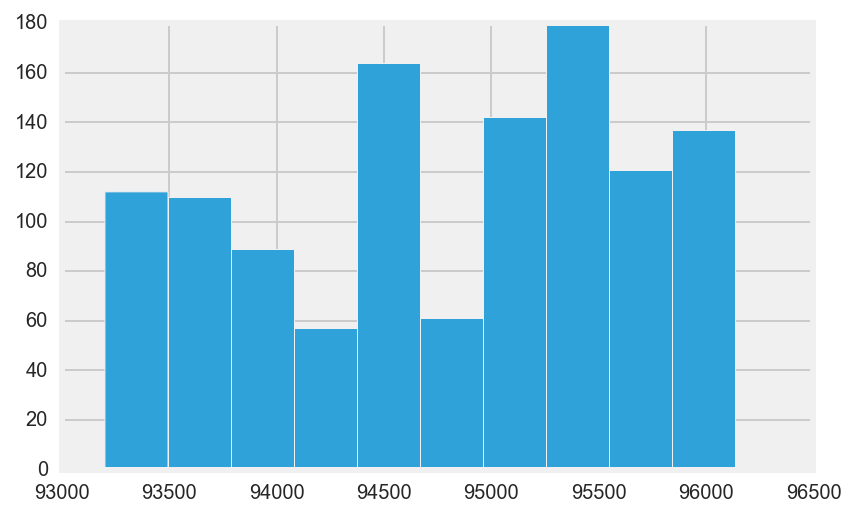

In [95]:
pge_q_num.ZipCode.hist()

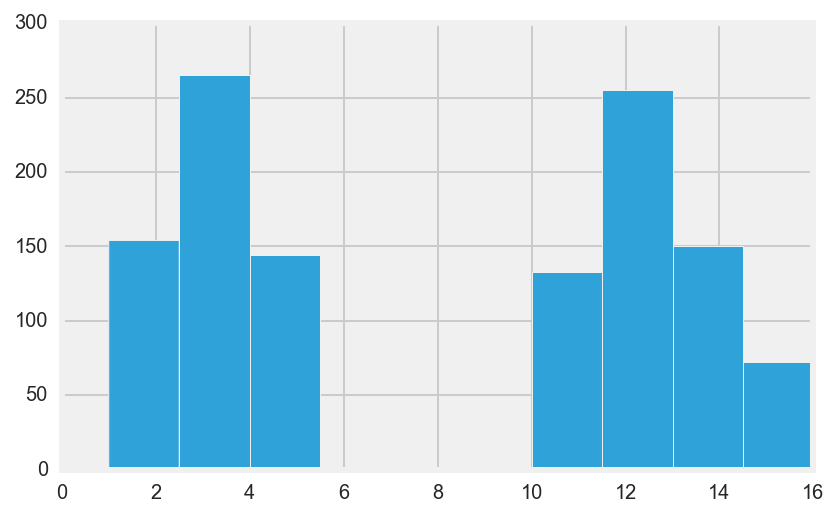

In [96]:
pge_q_num.zone.hist()

In [97]:
pge_q_num_corr  =  pge_q_num.corr()
pge_q_num_corr

,ZipCode,Month,Year,CustomerClass,Combined,TotalCustomers,TotalkWh,AveragekWh,zone,avg_temp
ZipCode,1.000000,-0.019442,0.032929,0.047498,NaN,-0.186749,-0.143983,-0.057802,0.109589,-0.470169
Month,-0.019442,1.000000,-0.049401,0.047878,NaN,0.012833,-0.010344,-0.003363,0.012851,0.001096
Year,0.032929,-0.049401,1.000000,-0.039327,NaN,-0.069765,-0.019571,0.063297,0.028978,0.007415
CustomerClass,0.047498,0.047878,-0.039327,1.000000,NaN,0.269445,-0.290305,-0.612243,0.161162,-0.043762
Combined,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TotalCustomers,-0.186749,0.012833,-0.069765,0.269445,NaN,1.000000,0.564046,-0.259542,-0.134887,0.161499
TotalkWh,-0.143983,-0.010344,-0.019571,-0.290305,NaN,0.564046,1.000000,0.403605,-0.117924,0.204043
AveragekWh,-0.057802,-0.003363,0.063297,-0.612243,NaN,-0.259542,0.403605,1.000000,-0.078973,0.086736
zone,0.109589,0.012851,0.028978,0.161162,NaN,-0.134887,-0.117924,-0.078973,1.000000,0.209293
avg_temp,-0.470169,0.001096,0.007415,-0.043762,NaN,0.161499,0.204043,0.086736,0.209293,1.000000


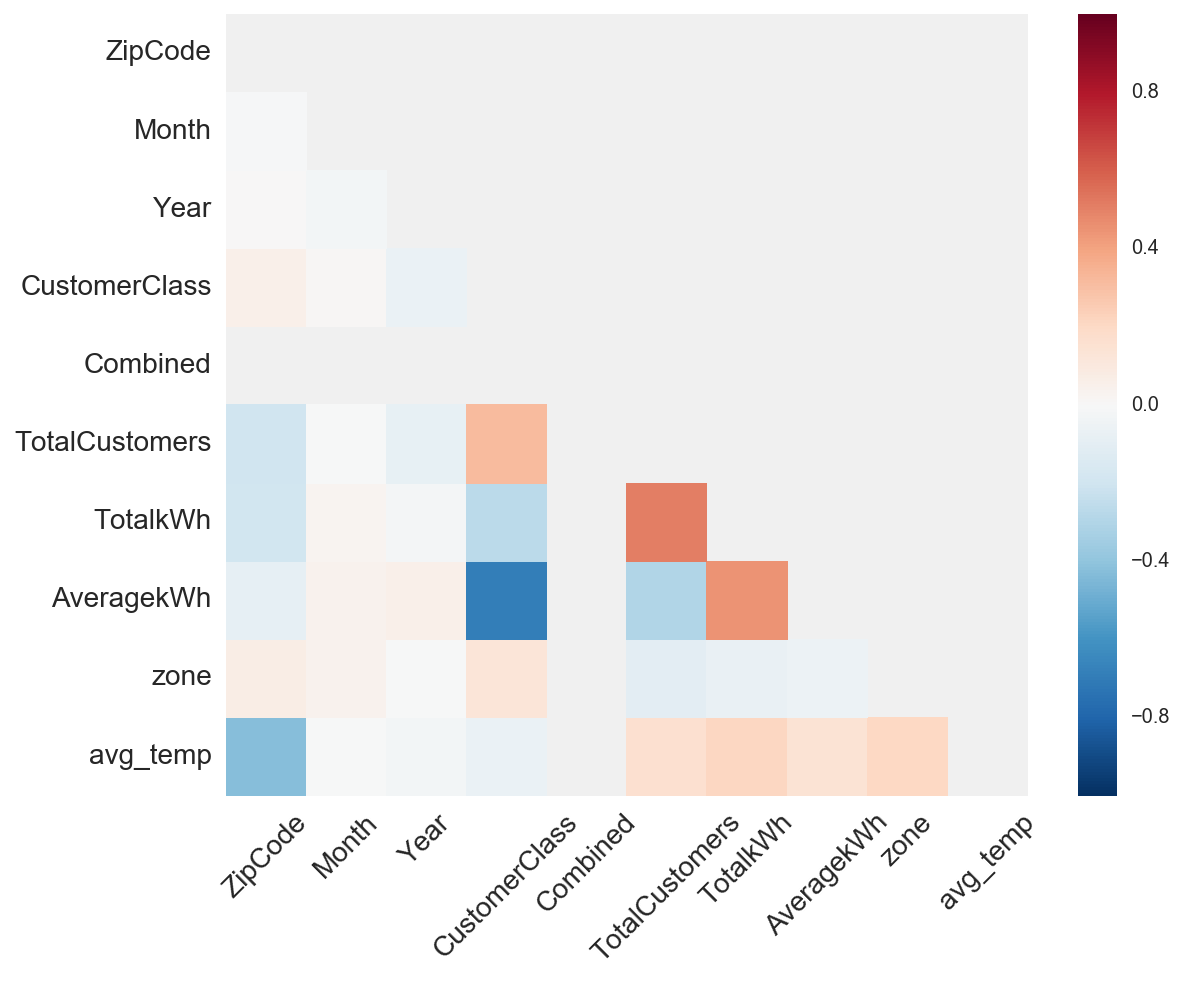

In [259]:
mask = np.zeros_like(pge_q_num_corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

fig, ax = plt.subplots(figsize=(8,7))
ax = sns.heatmap(pge_q_num_corr, mask=mask)

ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=14, rotation=45)
ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=14, rotation=0)

plt.show()

Looking just at PG&E consumption data, we see that there is strong anti-correlation
between "TotalKWh" and "Month", and anti-corellation with "CustomerClass".

So interesting vars are TotalCustomers, TotalkWh, zone, AveragekWh

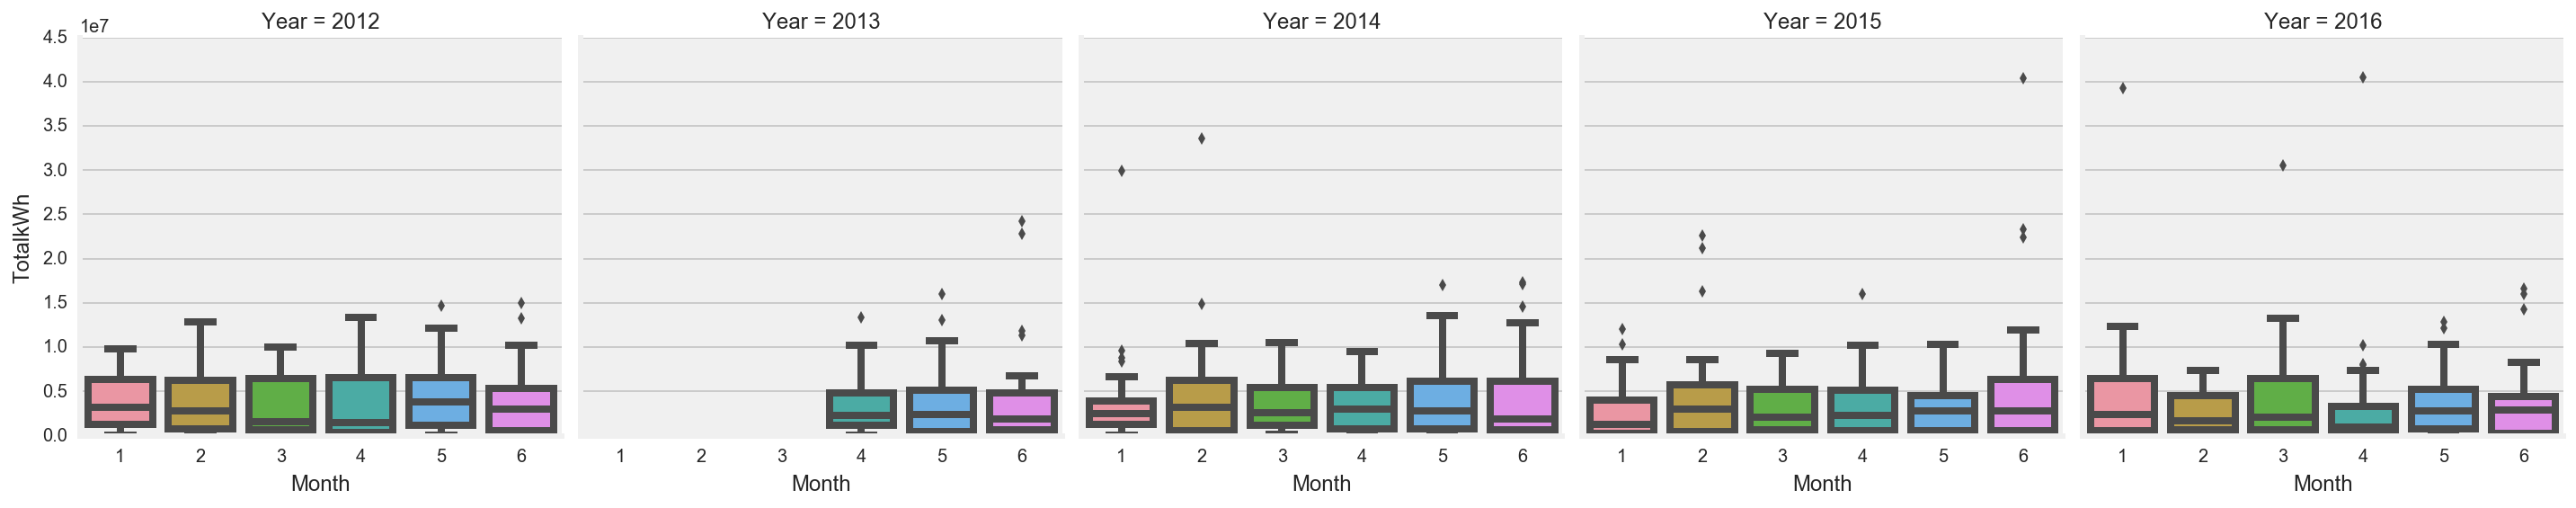

In [260]:
sns.factorplot(x='Month', y='TotalkWh',col='Year', kind='box', data=pge_q_num)

Add avg_temp to the CA solar df

In [98]:
ca_solar_df_num['avg_temp'] = ca_solar_df_num['zone'].map(ca_2015_1_6_ave_dict)

/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [99]:
ca_solar_df_num.dropna(inplace=True)

/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


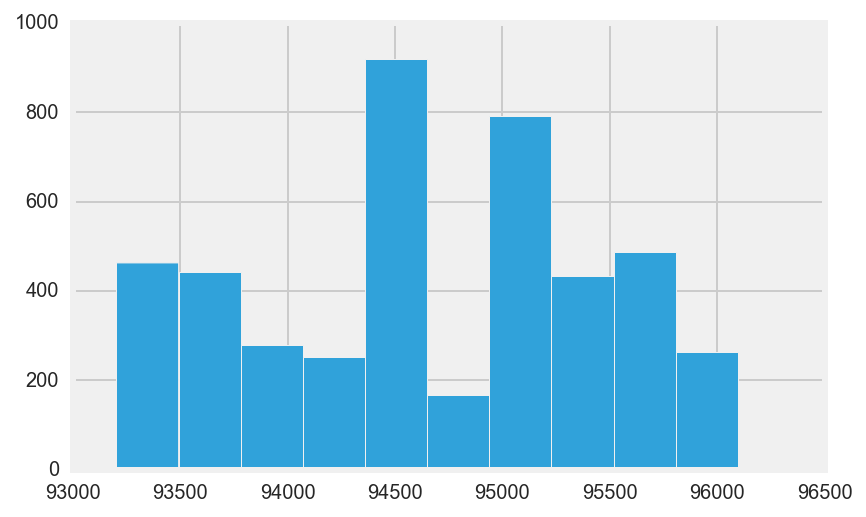

In [100]:
ca_solar_df_num.ZIP.hist()

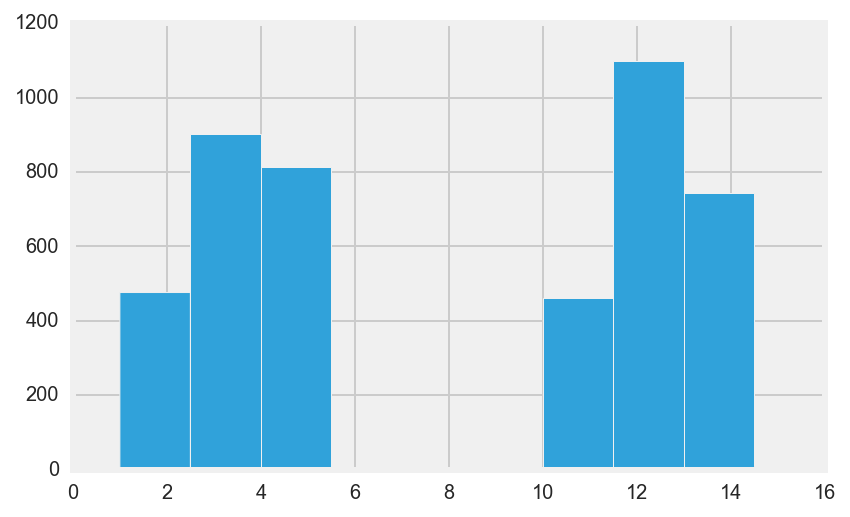

In [101]:
ca_solar_df_num.zone.hist()

In [102]:
ca_solar_df_num_corr  =  ca_solar_df_num.corr()
ca_solar_df_num_corr

,Nameplate_Rating,CEC_PTC_Rating,CSI_Rating,CEC_PTC_Rating_Single_Axis_Tracking,CEC_PTC_Rating_Dual_Axis_Tracking,CSI_Rating_Single_Axis_Tracking,CSI_Rating_Dual_Axis_Tracking,ZIP,zone,avg_temp
Nameplate_Rating,1.000000,0.999819,0.991407,0.355855,0.030004,0.355683,0.029983,-0.011278,0.041319,0.015900
CEC_PTC_Rating,0.999819,1.000000,0.991757,0.360526,0.028507,0.360233,0.028489,-0.011637,0.041097,0.016460
CSI_Rating,0.991407,0.991757,1.000000,0.464977,0.041006,0.465530,0.040972,-0.016514,0.045176,0.019567
CEC_PTC_Rating_Single_Axis_Tracking,0.355855,0.360526,0.464977,1.000000,0.018651,0.998956,0.018466,-0.020379,0.034846,0.018435
CEC_PTC_Rating_Dual_Axis_Tracking,0.030004,0.028507,0.041006,0.018651,1.000000,0.018934,0.999871,0.023742,0.013534,-0.023683
CSI_Rating_Single_Axis_Tracking,0.355683,0.360233,0.465530,0.998956,0.018934,1.000000,0.018746,-0.020766,0.034551,0.018851
CSI_Rating_Dual_Axis_Tracking,0.029983,0.028489,0.040972,0.018466,0.999871,0.018746,1.000000,0.024089,0.013250,-0.024009
ZIP,-0.011278,-0.011637,-0.016514,-0.020379,0.023742,-0.020766,0.024089,1.000000,-0.104723,-0.470381
zone,0.041319,0.041097,0.045176,0.034846,0.013534,0.034551,0.013250,-0.104723,1.000000,0.417058
avg_temp,0.015900,0.016460,0.019567,0.018435,-0.023683,0.018851,-0.024009,-0.470381,0.417058,1.000000


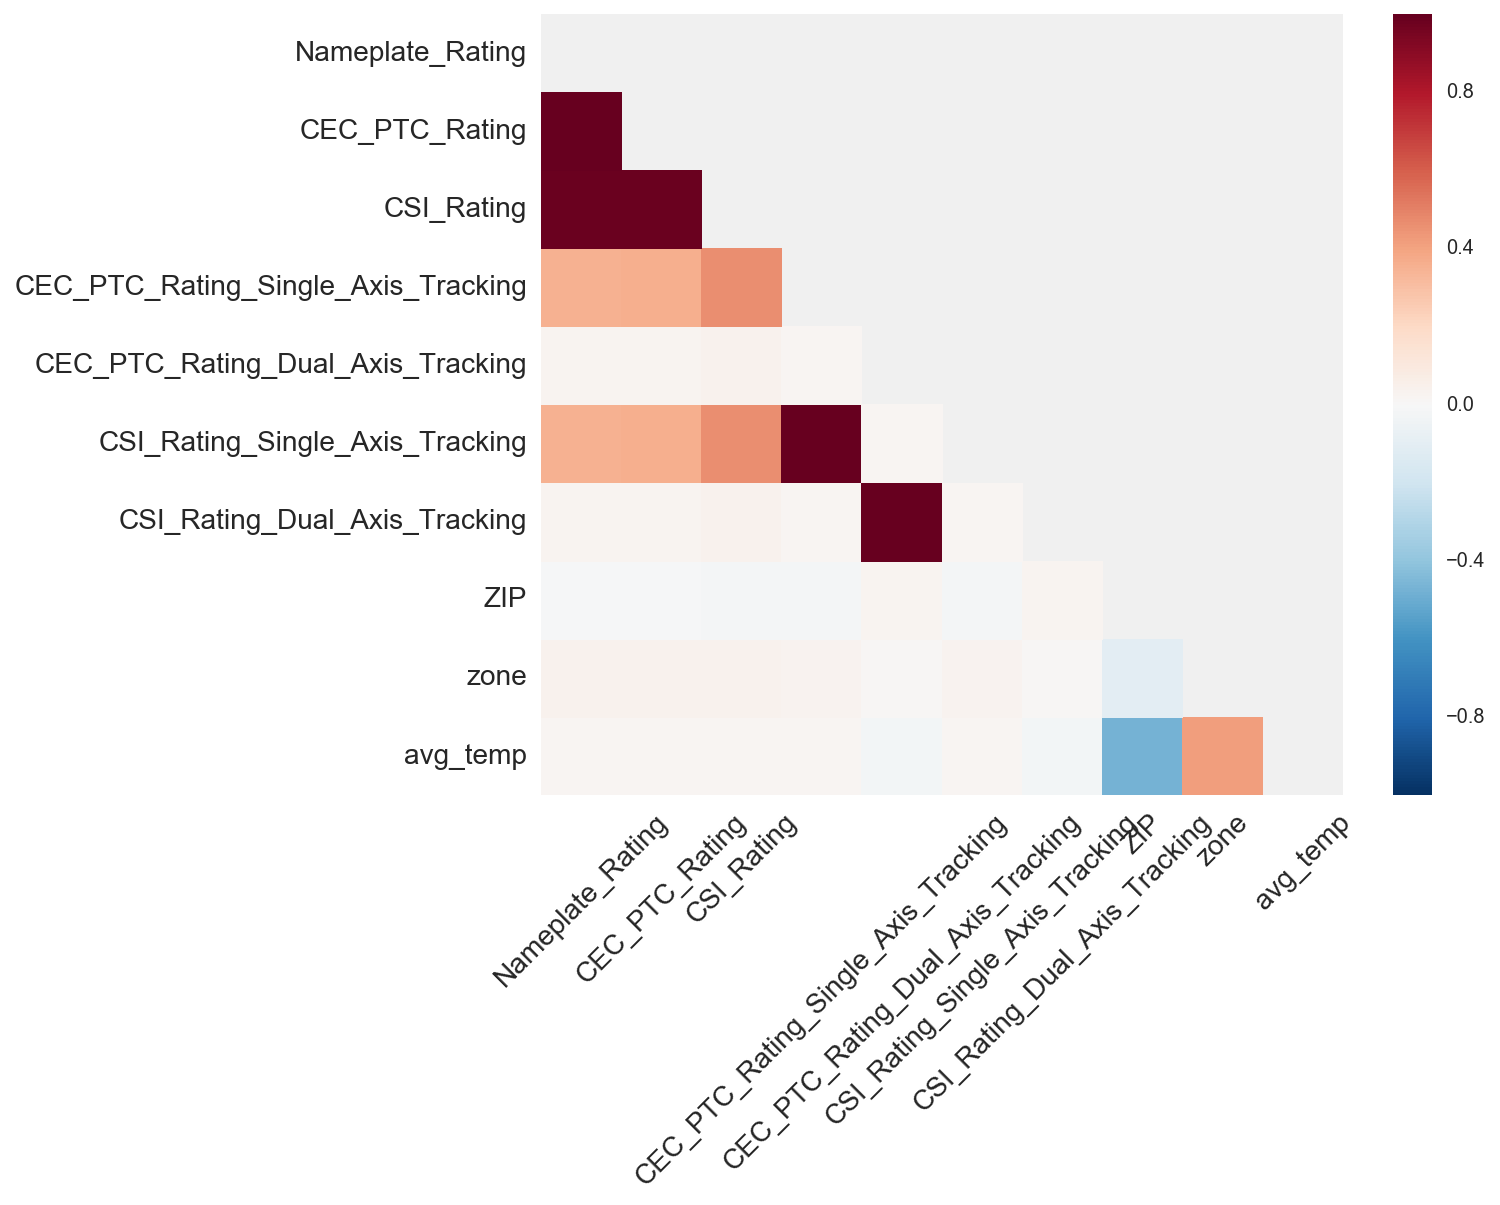

In [103]:
mask = np.zeros_like(ca_solar_df_num_corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

fig, ax = plt.subplots(figsize=(8,7))
ax = sns.heatmap(ca_solar_df_num_corr, mask=mask)

ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=14, rotation=45)
ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=14, rotation=0)

plt.show()

So interesting vars are Nameplate Rating, CEC PTC Rating, CSI Rating, zone, avg_temp

<h2> 3. Let's do now some analysis. 
<br>
3.1 First, we do some linear regression. </h2>

In [134]:
target = 'TotalkWh'
non_target_cols = ['AveragekWh', 'Month', 'TotalCustomers', 'ZipCode', 'CustomerClass', 'zone', 
                   'avg_temp']
formula_simple = target + ' ~ ' + ' + '.join(non_target_cols) + ' -1'
print formula_simple

TotalkWh ~ AveragekWh + Month + TotalCustomers + ZipCode + CustomerClass + zone + avg_temp -1


In [135]:
Y, X = patsy.dmatrices(formula_simple, data=pge_q_num)

In [136]:
simple_feature_names = X.design_info.column_names

In [137]:
pge_q_num.head(3)

,ZipCode,Month,Year,CustomerClass,Combined,TotalCustomers,TotalkWh,AveragekWh,zone,avg_temp
4011,95329,2,2012,2,1,1047.0,654735.0,625.0,12.0,57.166667
6132,94572,6,2016,2,1,2741.0,1359822.0,496.0,3.0,55.000000
2977,93906,2,2012,1,1,503.0,3957274.0,7867.0,3.0,55.000000


In [138]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
Xn = ss.fit_transform(pge_q_num)

In [139]:
linreg = LinearRegression()

linreg_scores = cross_val_score(linreg, Xn, Y, cv=10)

print linreg_scores
print np.mean(linreg_scores)

[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
1.0


<h2> 3.2 Now Ridge with cross-validation </h2>

In [140]:
ridge_alphas = np.logspace(0, 5, 200)

optimal_ridge = RidgeCV(alphas=ridge_alphas, cv=10)
optimal_ridge.fit(Xn, Y)

print optimal_ridge.alpha_

1.0


In [111]:
ridge = Ridge(alpha=optimal_ridge.alpha_)

ridge_scores = cross_val_score(ridge, Xn, Y, cv=10)

print ridge_scores
print np.mean(ridge_scores)

[ 0.99999759  0.99999587  0.99999534  0.9999977   0.99999821  0.99999823
  0.99999679  0.99999416  0.99999841  0.99999765]
0.999996996454


<h2> 3.3 Now Lasso cross-validation. </h2>

In [141]:
optimal_lasso = LassoCV(n_alphas=500, cv=10, verbose=1)
optimal_lasso.fit(Xn, Y)

print optimal_lasso.alpha_

/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:1051: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
...............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

3828.66806426


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.6s finished


In [142]:
lasso = Lasso(alpha=optimal_lasso.alpha_)

lasso_scores = cross_val_score(lasso, Xn, Y, cv=10)

print lasso_scores
print np.mean(lasso_scores)

[ 0.99999906  0.99999889  0.99999893  0.99999897  0.99999901  0.99999901
  0.99999889  0.99999903  0.99999904  0.99999897]
0.999998981386


Seems a bit too good....

OK, both Ridge and Lasso give good answers w cross validation. 

<h2> 3.4 Let's look at ElasticNet now.  </h2>

In [143]:
def elasticnet_coefs(X, Y, alphas):
    coefs = []
    l1_ratios = alphas

    #enet_reg = ElasticNetCV()
    enet_reg = ElasticNet()
    for a in alphas:
        #enet_reg.set_params(l1_ratio=l1_ratios, n_alphas=100, cv=5,verbose=1)
        enet_reg.set_params(alpha=a, l1_ratio=0.05)
        enet_reg.fit(X, Y)
        coefs.append(enet_reg.coef_)
        
    return coefs

In [144]:
enet_alphas = np.arange(0, 3.0, 0.05)
enet_coefs = elasticnet_coefs(X, Y, enet_alphas)

/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/ipykernel/__main__.py:10: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator


In [145]:
from cycler import cycler

def coef_plotter(alphas, coefs, feature_names, to_alpha, regtype='ridge'):
    
    # Get the full range of alphas before subsetting to keep the plots from 
    # resetting axes each time. (We use these values to set static axes later).
    amin = np.min(alphas)
    amax = np.max(alphas)
    
    # Subset the alphas and coefficients to just the ones below the set limit
    # from the interactive widget:
    alphas = [a for a in alphas if a <= to_alpha]
    coefs = coefs[0:len(alphas)]
    
    # Get some colors from seaborn:
    colors = sns.color_palette("husl", len(coefs[0]))
    
    # Get the figure and reset the size to be wider:
    fig = plt.figure()
    fig.set_size_inches(18,7)

    # We have two axes this time on our figure. 
    # The fig.add_subplot adds axes to our figure. The number inside stands for:
    #[figure_rows|figure_cols|position_of_current_axes]
    ax1 = fig.add_subplot(121)
    
    # Give it the color cycler:
    ax1.set_prop_cycle(cycler('color', colors))
    
    # Print a vertical line showing our current alpha threshold:
    ax1.axvline(to_alpha, lw=2, ls='dashed', c='k', alpha=0.4)
    
    # Plot the lines of the alphas on x-axis and coefficients on y-axis
    ax1.plot(alphas, coefs, lw=2)
    
    # set labels for axes:
    ax1.set_xlabel('alpha', fontsize=20)
    ax1.set_ylabel('coefficients', fontsize=20)
    
    # If this is for the ridge, set this to a log scale on the x-axis:
    if regtype == 'ridge':
        ax1.set_xscale('log')
    
    # Enforce the axis limits:
    ax1.set_xlim([amin, amax])
    
    # Put a title on the axis
    ax1.set_title(regtype+' coef paths\n', fontsize=20)
    
    # Get the ymin and ymax for this axis to enforce it to be the same on the 
    # second chart:
    ymin, ymax = ax1.get_ylim()

    # Add our second axes for the barplot in position 2:
    ax2 = fig.add_subplot(122)
    
    # Position the bars according to their index from the feature names variable:
    ax2.bar(range(1, len(feature_names)+1), coefs[-1], align='center', color=colors)
    ax2.set_xticks(range(1, len(feature_names)+1))
    
    # Reset the ticks from numbers to acutally be the names:
    ax2.set_xticklabels(feature_names, rotation=65, fontsize=12)
    
    # enforce limits and add titles, labels
    ax2.set_ylim([ymin, ymax])
    ax2.set_title(regtype+' predictor coefs\n', fontsize=20)
    ax2.set_xlabel('coefficients', fontsize=20)
    ax2.set_ylabel('alpha', fontsize=20)
    
    plt.show()

In [146]:
from ipywidgets import *
from IPython.display import display

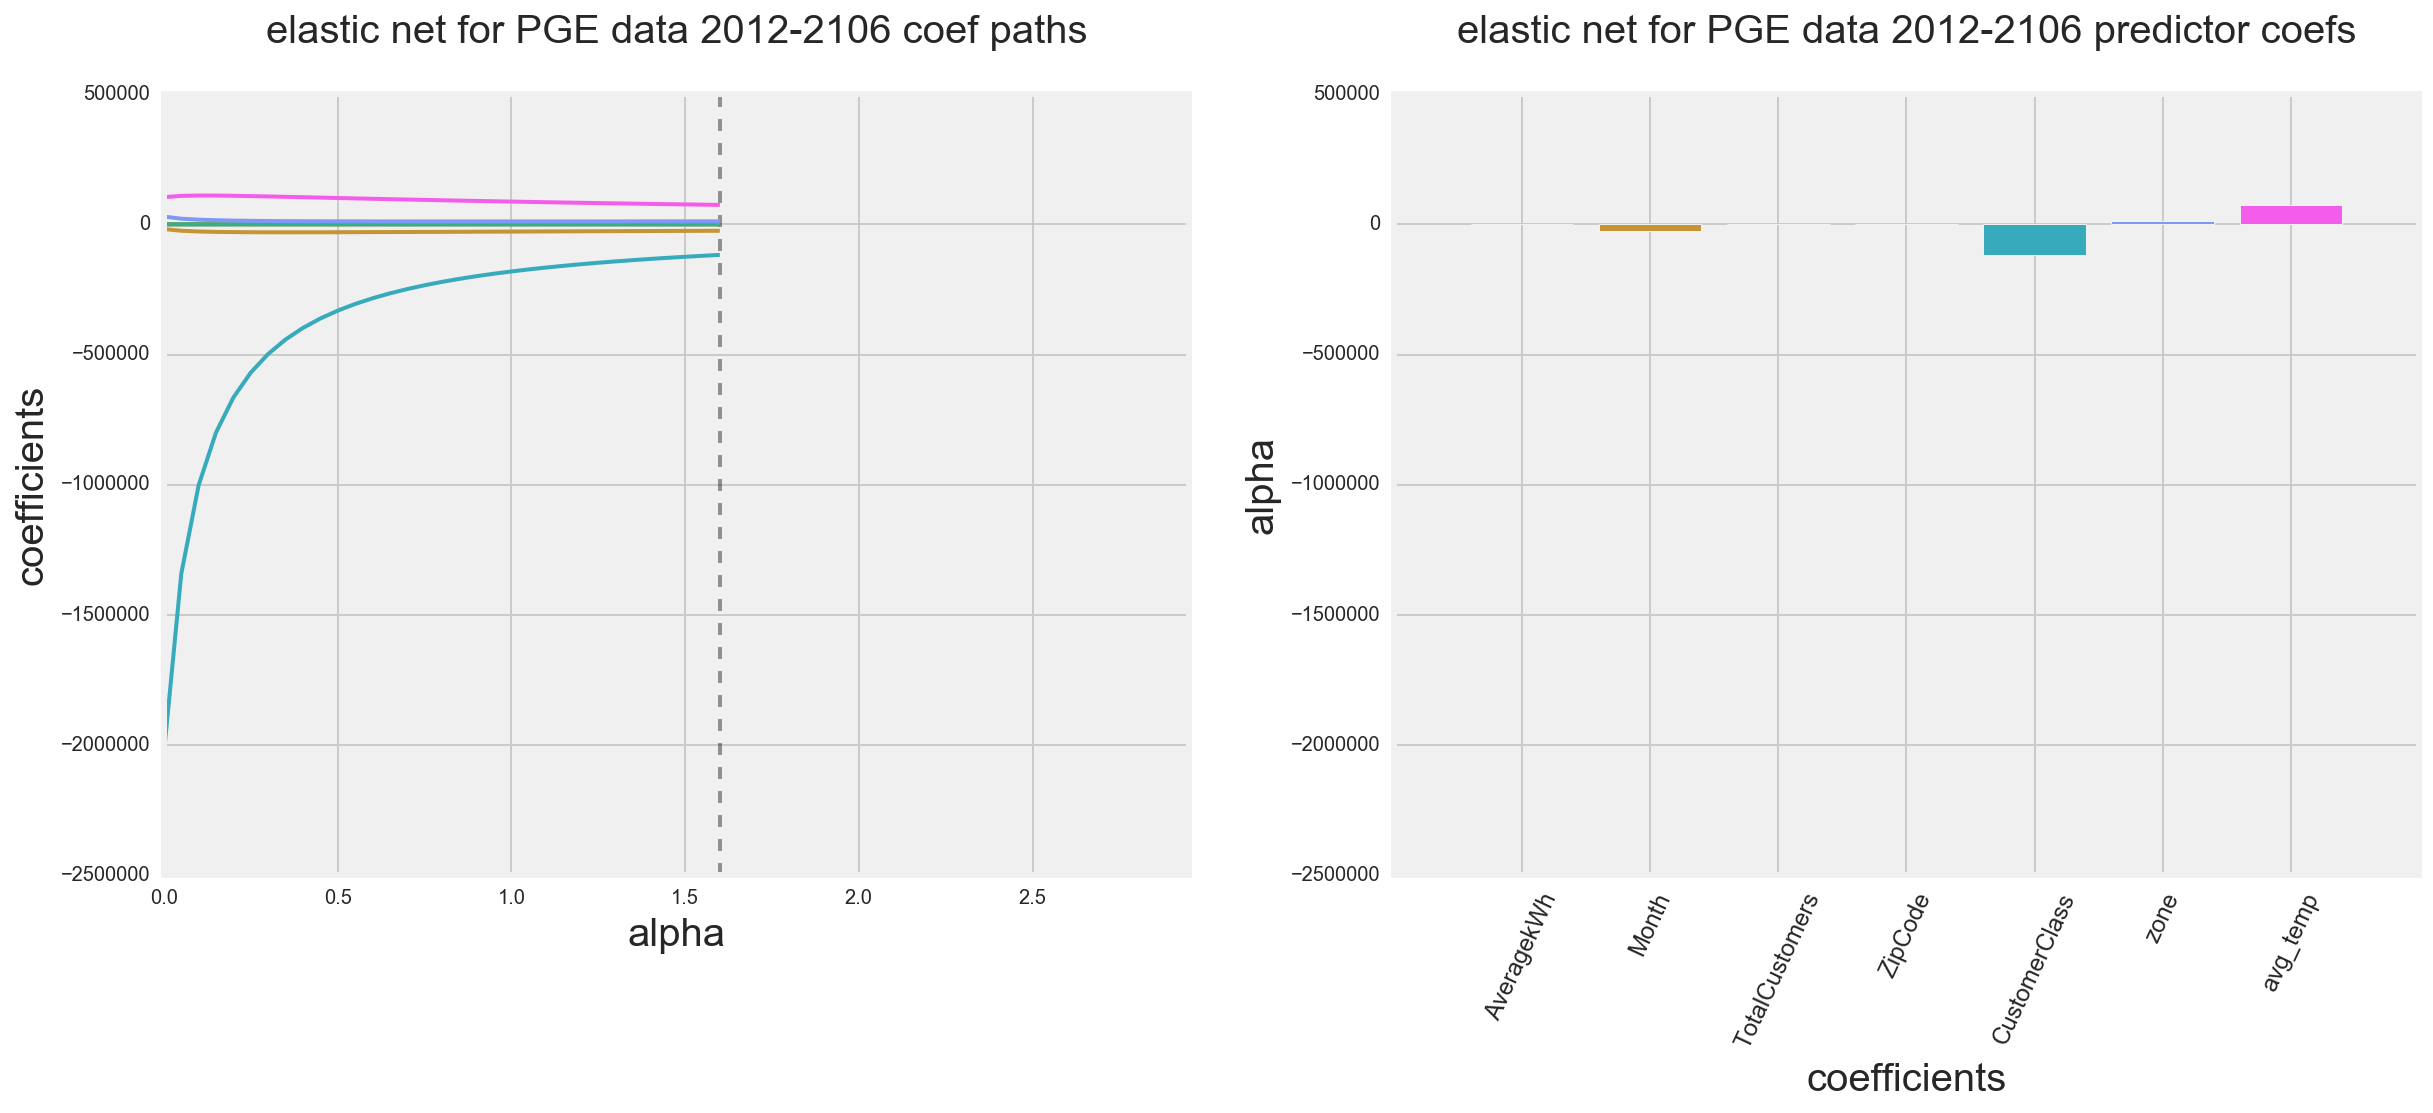

<function __main__.enet_plot_runner>

In [147]:
def enet_plot_runner(alpha=1.60):
    coef_plotter(enet_alphas, enet_coefs, simple_feature_names, alpha, 
                 regtype='elastic net for PGE data 2012-2106')

interact(enet_plot_runner, alpha=(0.0,3.0,0.05))

Looking just at PG&E consumption data, we see that 'TotalkWh' correlates with "zone" and "avg_temp" anti-correlation between "TotalKWh" and "Month", and anti-corellation with "CustomerClass".

<h2>  3.5 Let's look now at Stochastic  Gradient Descent. </h2>

In [148]:
sgd_params = {
    'loss':['squared_loss'],
    'penalty':['l1','l2'],
    'alpha':np.linspace(0.01, 10000, 100)
}

sgd_reg = SGDRegressor()
sgd_reg_gs = GridSearchCV(sgd_reg, sgd_params, cv=5, verbose=2)

In [149]:
sgd_reg_gs.fit(Xn, Y)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
[CV] penalty=l1, alpha=0.01, loss=squared_loss .......................
[CV] .............. penalty=l1, alpha=0.01, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=0.01, loss=squared_loss .......................
[CV] .............. penalty=l1, alpha=0.01, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=0.01, loss=squared_loss .......................
[CV] .............. penalty=l1, alpha=0.01, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=0.01, loss=squared_loss .......................
[CV] .............. penalty=l1, alpha=0.01, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=0.01, loss=squared_loss .......................
[CV] .............. penalty=l1, alpha=0.01, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=0.01, loss=squared_loss .......................
[CV] .............. penalty=l2, alpha=0.01, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=0.01, loss=squared_loss .......................
[CV] ........

/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d arr

[CV] ............ penalty=l1, alpha=303.04, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=303.04, loss=squared_loss .....................
[CV] ............ penalty=l1, alpha=303.04, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=303.04, loss=squared_loss .....................
[CV] ............ penalty=l1, alpha=303.04, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=303.04, loss=squared_loss .....................
[CV] ............ penalty=l2, alpha=303.04, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=303.04, loss=squared_loss .....................
[CV] ............ penalty=l2, alpha=303.04, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=303.04, loss=squared_loss .....................
[CV] ............ penalty=l2, alpha=303.04, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=303.04, loss=squared_loss .....................
[CV] ............ penalty=l2, alpha=303.04, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=303.04, loss=squared_loss .....................
[CV] .

/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d arr

[CV] ............ penalty=l2, alpha=606.07, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=707.08, loss=squared_loss .....................
[CV] ............ penalty=l1, alpha=707.08, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=707.08, loss=squared_loss .....................
[CV] ............ penalty=l1, alpha=707.08, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=707.08, loss=squared_loss .....................
[CV] ............ penalty=l1, alpha=707.08, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=707.08, loss=squared_loss .....................
[CV] ............ penalty=l1, alpha=707.08, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=707.08, loss=squared_loss .....................
[CV] ............ penalty=l1, alpha=707.08, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=707.08, loss=squared_loss .....................
[CV] ............ penalty=l2, alpha=707.08, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=707.08, loss=squared_loss .....................
[CV] .

/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d arr

[CV] ........... penalty=l1, alpha=1111.12, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=1111.12, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=1111.12, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=1111.12, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=1111.12, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=1111.12, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=1111.12, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=1111.12, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=1111.12, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=1111.12, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=1111.12, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=1111.12, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=1111.12, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=1212.13, loss=squared_loss ....................
[CV] .

/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[Parallel(n_jobs=1)]: Done 161 tasks       | elapsed:    0.8s
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: Dat

[CV] ........... penalty=l2, alpha=1515.16, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=1616.17, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=1616.17, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=1616.17, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=1616.17, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=1616.17, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=1616.17, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=1616.17, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=1616.17, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=1616.17, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=1616.17, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=1616.17, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=1616.17, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=1616.17, loss=squared_loss ....................
[CV] .

/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d arr

[CV] ........... penalty=l1, alpha=2020.21, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=2020.21, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=2020.21, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=2020.21, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=2020.21, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=2020.21, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=2020.21, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=2020.21, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=2020.21, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=2020.21, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=2020.21, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=2020.21, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=2020.21, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=2020.21, loss=squared_loss ....................
[CV] .

/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d arr

[CV] ........... penalty=l2, alpha=2323.24, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=2323.24, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=2323.24, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=2424.25, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=2424.25, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=2424.25, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=2424.25, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=2424.25, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=2424.25, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=2424.25, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=2424.25, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=2424.25, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=2424.25, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=2424.25, loss=squared_loss ....................
[CV] .

/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d arr

[CV] ........... penalty=l1, alpha=2828.29, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=2828.29, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=2828.29, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=2828.29, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=2828.29, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=2828.29, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=2828.29, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=2828.29, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=2828.29, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=2828.29, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=2828.29, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=2828.29, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=2828.29, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=2828.29, loss=squared_loss ....................
[CV] .

/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d arr

[CV] ........... penalty=l1, alpha=3232.33, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=3232.33, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=3232.33, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=3232.33, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=3232.33, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=3232.33, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=3232.33, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=3232.33, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=3232.33, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=3232.33, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=3232.33, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=3232.33, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=3232.33, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=3232.33, loss=squared_loss ....................
[CV] .

/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[Parallel(n_jobs=1)]: Done 364 tasks       | elapsed:    1.9s
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: Dat

[CV] ........... penalty=l1, alpha=3636.37, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=3636.37, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=3636.37, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=3636.37, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=3636.37, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=3636.37, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=3636.37, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=3636.37, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=3636.37, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=3636.37, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=3636.37, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=3636.37, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=3636.37, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=3636.37, loss=squared_loss ....................
[CV] .

/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d arr

[CV] ........... penalty=l2, alpha=4040.41, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=4141.42, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=4141.42, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=4141.42, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=4141.42, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=4141.42, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=4141.42, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=4141.42, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=4141.42, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=4141.42, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=4141.42, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=4141.42, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=4141.42, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=4141.42, loss=squared_loss ....................
[CV] .

/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d arr

[CV] ........... penalty=l1, alpha=4444.45, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=4444.45, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=4444.45, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=4444.45, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=4444.45, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=4444.45, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=4444.45, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=4444.45, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=4444.45, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=4444.45, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=4444.45, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=4444.45, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=4444.45, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=4545.46, loss=squared_loss ....................
[CV] .

/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d arr

[CV] ........... penalty=l2, alpha=4747.48, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=4848.49, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=4848.49, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=4848.49, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=4848.49, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=4848.49, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=4848.49, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=4848.49, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=4848.49, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=4848.49, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=4848.49, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=4848.49, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=4848.49, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=4848.49, loss=squared_loss ....................
[CV] .

/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d arr

[CV] ........... penalty=l2, alpha=5151.52, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=5151.52, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=5151.52, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=5151.52, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=5151.52, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=5151.52, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=5151.52, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=5151.52, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=5151.52, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=5252.53, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=5252.53, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=5252.53, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=5252.53, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=5252.53, loss=squared_loss ....................
[CV] .

/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d arr

[CV] ........... penalty=l1, alpha=5555.56, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=5555.56, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=5555.56, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=5555.56, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=5555.56, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=5555.56, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=5555.56, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=5555.56, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=5555.56, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=5555.56, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=5555.56, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=5656.57, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=5656.57, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=5656.57, loss=squared_loss ....................
[CV] .

/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d arr

[CV] ............ penalty=l1, alpha=5959.6, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=5959.6, loss=squared_loss .....................
[CV] ............ penalty=l1, alpha=5959.6, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=5959.6, loss=squared_loss .....................
[CV] ............ penalty=l1, alpha=5959.6, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=5959.6, loss=squared_loss .....................
[CV] ............ penalty=l1, alpha=5959.6, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=5959.6, loss=squared_loss .....................
[CV] ............ penalty=l2, alpha=5959.6, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=5959.6, loss=squared_loss .....................
[CV] ............ penalty=l2, alpha=5959.6, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=5959.6, loss=squared_loss .....................
[CV] ............ penalty=l2, alpha=5959.6, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=5959.6, loss=squared_loss .....................
[CV] .

/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d arr

[CV] ........... penalty=l2, alpha=6262.63, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=6262.63, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=6262.63, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=6262.63, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=6262.63, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=6262.63, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=6262.63, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=6262.63, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=6262.63, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=6363.64, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=6363.64, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=6363.64, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=6363.64, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=6363.64, loss=squared_loss ....................
[CV] .

/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d arr

[CV] penalty=l2, alpha=6666.67, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=6666.67, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=6666.67, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=6666.67, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=6666.67, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=6666.67, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=6666.67, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=6666.67, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=6767.68, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=6767.68, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=6767.68, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=6767.68, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=6767.68, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=6767.68, loss=squared_loss -   0.0s
[CV] p

/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d arr

[CV] ........... penalty=l2, alpha=7070.71, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=7070.71, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=7070.71, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=7171.72, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=7171.72, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=7171.72, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=7171.72, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=7171.72, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=7171.72, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=7171.72, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=7171.72, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=7171.72, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=7171.72, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=7171.72, loss=squared_loss ....................
[CV] .

/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d arr

[CV] ........... penalty=l2, alpha=7575.76, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=7575.76, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=7575.76, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=7575.76, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=7575.76, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=7575.76, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=7575.76, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=7676.77, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=7676.77, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=7676.77, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=7676.77, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=7676.77, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=7676.77, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=7676.77, loss=squared_loss ....................
[CV] .

/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d arr

[CV] ............ penalty=l2, alpha=7979.8, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=7979.8, loss=squared_loss .....................
[CV] ............ penalty=l2, alpha=7979.8, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=7979.8, loss=squared_loss .....................
[CV] ............ penalty=l2, alpha=7979.8, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=8080.81, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=8080.81, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=8080.81, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=8080.81, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=8080.81, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=8080.81, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=8080.81, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=8080.81, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=8080.81, loss=squared_loss ....................
[CV] .

/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d arr

[CV] ........... penalty=l2, alpha=8383.84, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=8383.84, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=8383.84, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=8383.84, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=8383.84, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=8383.84, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=8383.84, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=8484.85, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=8484.85, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=8484.85, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=8484.85, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=8484.85, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=8484.85, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=8484.85, loss=squared_loss ....................
[CV] .

/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d arr

[CV] ........... penalty=l1, alpha=8888.89, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=8888.89, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=8888.89, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=8888.89, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=8888.89, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=8888.89, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=8888.89, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=8888.89, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=8888.89, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=8888.89, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=8888.89, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=8888.89, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=8888.89, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=8888.89, loss=squared_loss ....................
[CV] .

/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d arr

[CV] ........... penalty=l1, alpha=9292.93, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=9292.93, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=9292.93, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=9292.93, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=9292.93, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=9292.93, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=9292.93, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=9292.93, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=9292.93, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=9292.93, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=9292.93, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=9292.93, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=9292.93, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=9393.94, loss=squared_loss ....................
[CV] .

/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d arr

[CV] ........... penalty=l2, alpha=9696.97, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=9696.97, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=9696.97, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=9696.97, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=9696.97, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=9696.97, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=9696.97, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=9797.98, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=9797.98, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=9797.98, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=9797.98, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=9797.98, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=9797.98, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=9797.98, loss=squared_loss ....................
[CV] .

/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d arr

GridSearchCV(cv=5, error_score='raise',
       estimator=SGDRegressor(alpha=0.0001, average=False, epsilon=0.1, eta0=0.01,
       fit_intercept=True, l1_ratio=0.15, learning_rate='invscaling',
       loss='squared_loss', n_iter=5, penalty='l2', power_t=0.25,
       random_state=None, shuffle=True, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'penalty': ['l1', 'l2'], 'loss': ['squared_loss'], 'alpha': array([  1.00000e-02,   1.01020e+02, ...,   9.89899e+03,   1.00000e+04])},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=2)

In [150]:
print sgd_reg_gs.best_params_
print sgd_reg_gs.best_score_
sgd_reg = sgd_reg_gs.best_estimator_

{'penalty': 'l1', 'alpha': 9292.9299999999985, 'loss': 'squared_loss'}
0.995531548069


That is a very good result.

This result seems too good. Let me do a time series analysis, see if we get as good are result there.
The data is monthly, Jan - Jun for 5 years, 2012-2016, so it might be ameanable to time series analysis. 

<h2> 3.9 Time series analysis. </h2>

In [152]:
avgkwh_diff  = pge_q_num.AveragekWh.diff()

In [153]:
avgkwh_diff.dropna(inplace=True)

In [154]:
totalkwh_diff = pge_q_num.TotalkWh.diff()

In [155]:
totalkwh_diff.dropna(inplace=True)

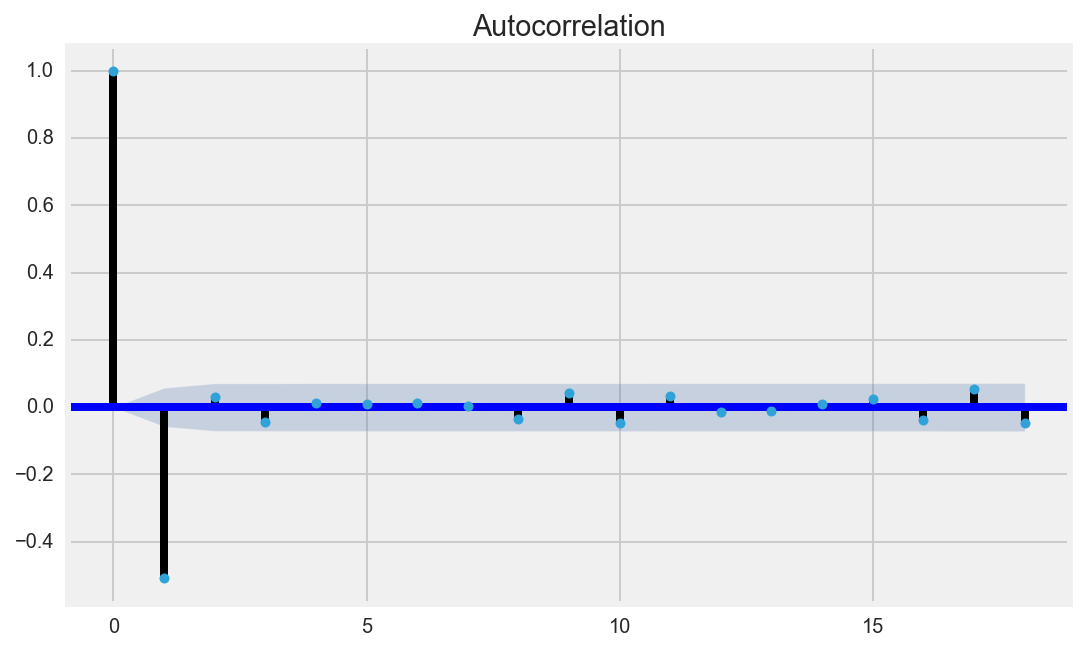

In [156]:
# pick the lag value at 18 = 6 * 3 the total number of data points we have for each avg kwh, total kwh
fig = plt.figure(figsize=(8,5))
ax = fig.gca()
plot_acf(avgkwh_diff, lags=18, ax=ax)
plt.show()

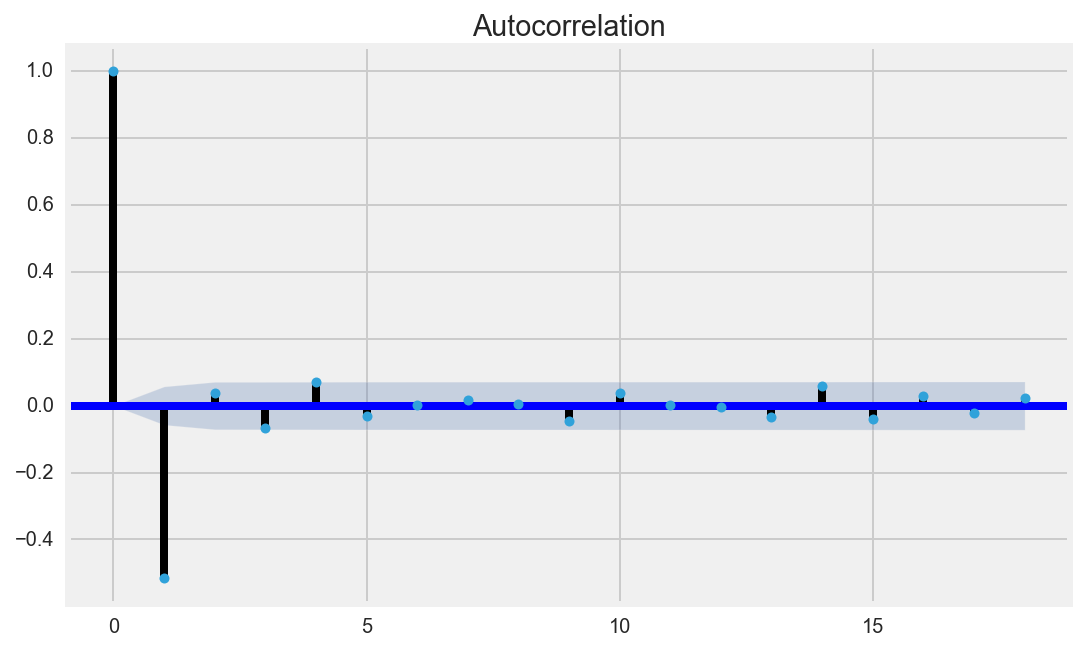

In [157]:
fig = plt.figure(figsize=(8,5))
ax = fig.gca()
plot_acf(totalkwh_diff, lags=18, ax=ax)
plt.show()

In [158]:
ar1 = ARMA(avgkwh_diff.values, (1,0)).fit()
ar1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                 1172
Model:                     ARMA(1, 0)   Log Likelihood              -11447.808
Method:                       css-mle   S.D. of innovations           4224.634
Date:                Fri, 30 Sep 2016   AIC                          22901.616
Time:                        16:28:46   BIC                          22916.815
Sample:                             0   HQIC                         22907.348
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          0.4428     81.823      0.005      0.996      -159.927   160.813
ar.L1.y       -0.5086      0.025    -20.243      0.000        -0.558    -0.459
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.9662           +0.0000j            1.9662            0.5000
-----------------------------------------------------------------------------
"""

In [159]:
ar2 = ARMA(totalkwh_diff.values, (1,0)).fit()
ar2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                 1172
Model:                     ARMA(1, 0)   Log Likelihood              -19670.117
Method:                       css-mle   S.D. of innovations        4705796.863
Date:                Fri, 30 Sep 2016   AIC                          39346.233
Time:                        16:28:47   BIC                          39361.433
Sample:                             0   HQIC                         39351.966
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const       -505.9377   9.07e+04     -0.006      0.996     -1.78e+05  1.77e+05
ar.L1.y       -0.5156      0.025    -20.619      0.000        -0.565    -0.467
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.9397           +0.0000j            1.9397            0.5000
-----------------------------------------------------------------------------
"""

In [160]:
r2_score(avgkwh_diff, ar1.fittedvalues)

0.259113282532344

In [161]:
r2_score(totalkwh_diff, ar2.fittedvalues)

0.26624013564026994

These results are not as high as the linear regression, but are probably more realistic.

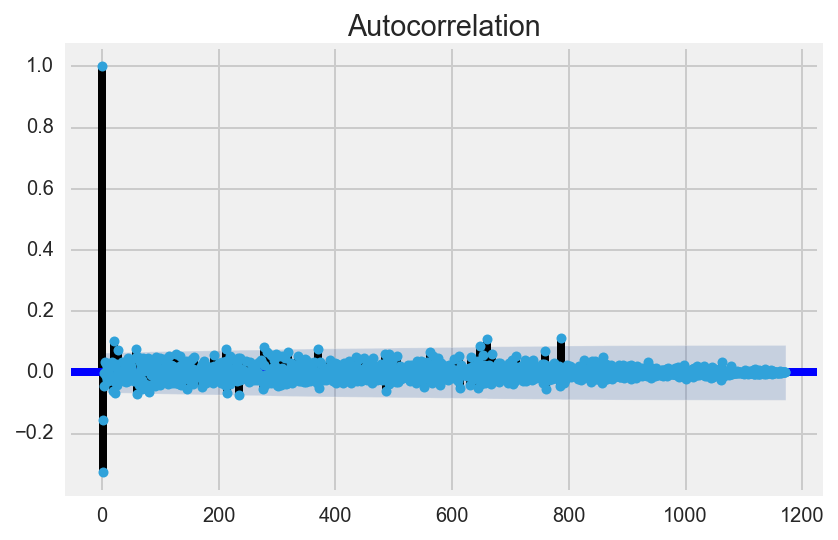

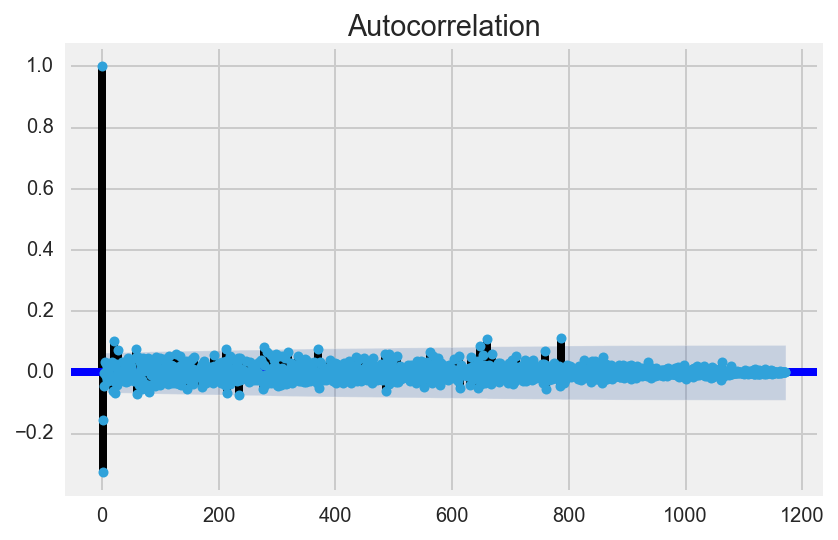

In [162]:
plot_acf(ar1.resid)

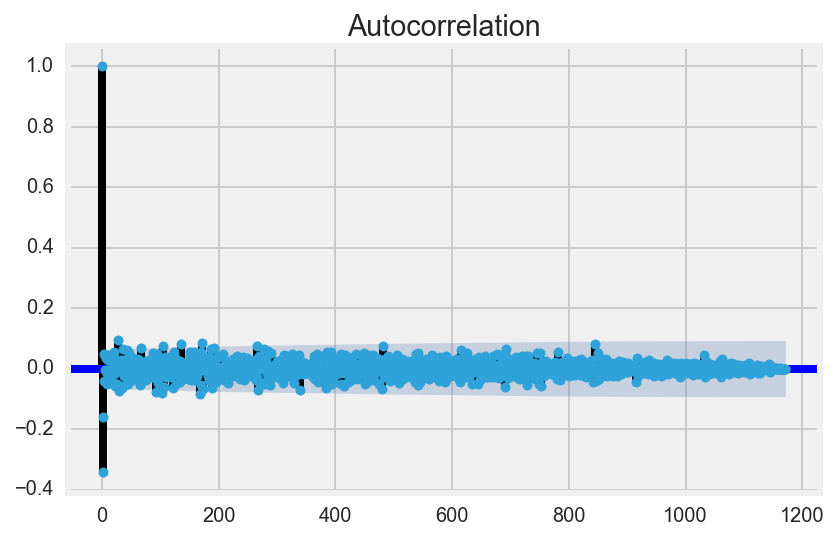

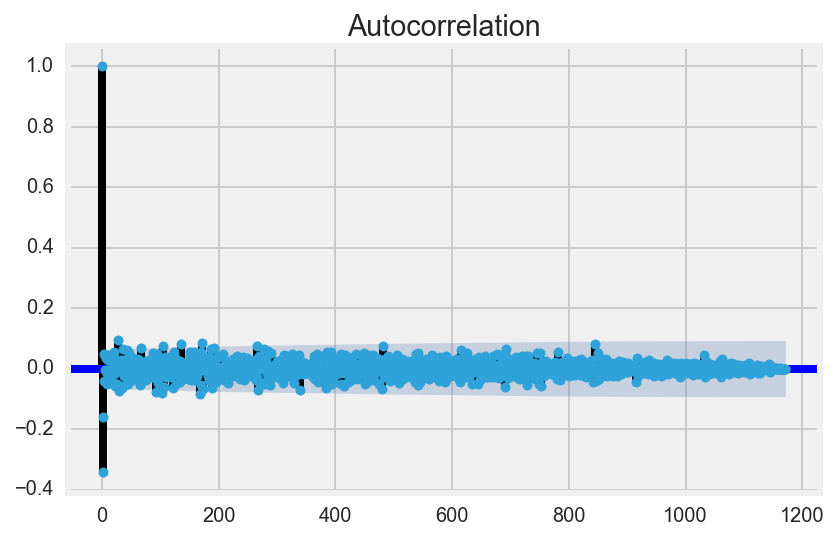

In [163]:
plot_acf(ar2.resid)

These plots show values close to 0 onthe y-axis, so they are trust-worthy. 

The auto-correlation plots look Ok also. No hidden auto-correlations.

<h2> 4. Let's turn now to the solar data analysis. </h2>

In [164]:
ca_solar_df_num_corr  =  ca_solar_df_num.corr()
ca_solar_df_num_corr

,Nameplate_Rating,CEC_PTC_Rating,CSI_Rating,CEC_PTC_Rating_Single_Axis_Tracking,CEC_PTC_Rating_Dual_Axis_Tracking,CSI_Rating_Single_Axis_Tracking,CSI_Rating_Dual_Axis_Tracking,ZIP,zone,avg_temp
Nameplate_Rating,1.000000,0.999819,0.991407,0.355855,0.030004,0.355683,0.029983,-0.011278,0.041319,0.015900
CEC_PTC_Rating,0.999819,1.000000,0.991757,0.360526,0.028507,0.360233,0.028489,-0.011637,0.041097,0.016460
CSI_Rating,0.991407,0.991757,1.000000,0.464977,0.041006,0.465530,0.040972,-0.016514,0.045176,0.019567
CEC_PTC_Rating_Single_Axis_Tracking,0.355855,0.360526,0.464977,1.000000,0.018651,0.998956,0.018466,-0.020379,0.034846,0.018435
CEC_PTC_Rating_Dual_Axis_Tracking,0.030004,0.028507,0.041006,0.018651,1.000000,0.018934,0.999871,0.023742,0.013534,-0.023683
CSI_Rating_Single_Axis_Tracking,0.355683,0.360233,0.465530,0.998956,0.018934,1.000000,0.018746,-0.020766,0.034551,0.018851
CSI_Rating_Dual_Axis_Tracking,0.029983,0.028489,0.040972,0.018466,0.999871,0.018746,1.000000,0.024089,0.013250,-0.024009
ZIP,-0.011278,-0.011637,-0.016514,-0.020379,0.023742,-0.020766,0.024089,1.000000,-0.104723,-0.470381
zone,0.041319,0.041097,0.045176,0.034846,0.013534,0.034551,0.013250,-0.104723,1.000000,0.417058
avg_temp,0.015900,0.016460,0.019567,0.018435,-0.023683,0.018851,-0.024009,-0.470381,0.417058,1.000000


In [165]:
ca_solar_df_num.head(3)

,Nameplate_Rating,CEC_PTC_Rating,CSI_Rating,CEC_PTC_Rating_Single_Axis_Tracking,CEC_PTC_Rating_Dual_Axis_Tracking,CSI_Rating_Single_Axis_Tracking,CSI_Rating_Dual_Axis_Tracking,ZIP,zone,avg_temp
12297,2.820,2.413,2.350,0.0,0.0,0.0,0.0,93950,3.0,55.000000
37044,5.075,4.339,3.603,0.0,0.0,0.0,0.0,95060,3.0,55.000000
10,7.750,6.791,6.479,0.0,0.0,0.0,0.0,93311,13.0,58.166667


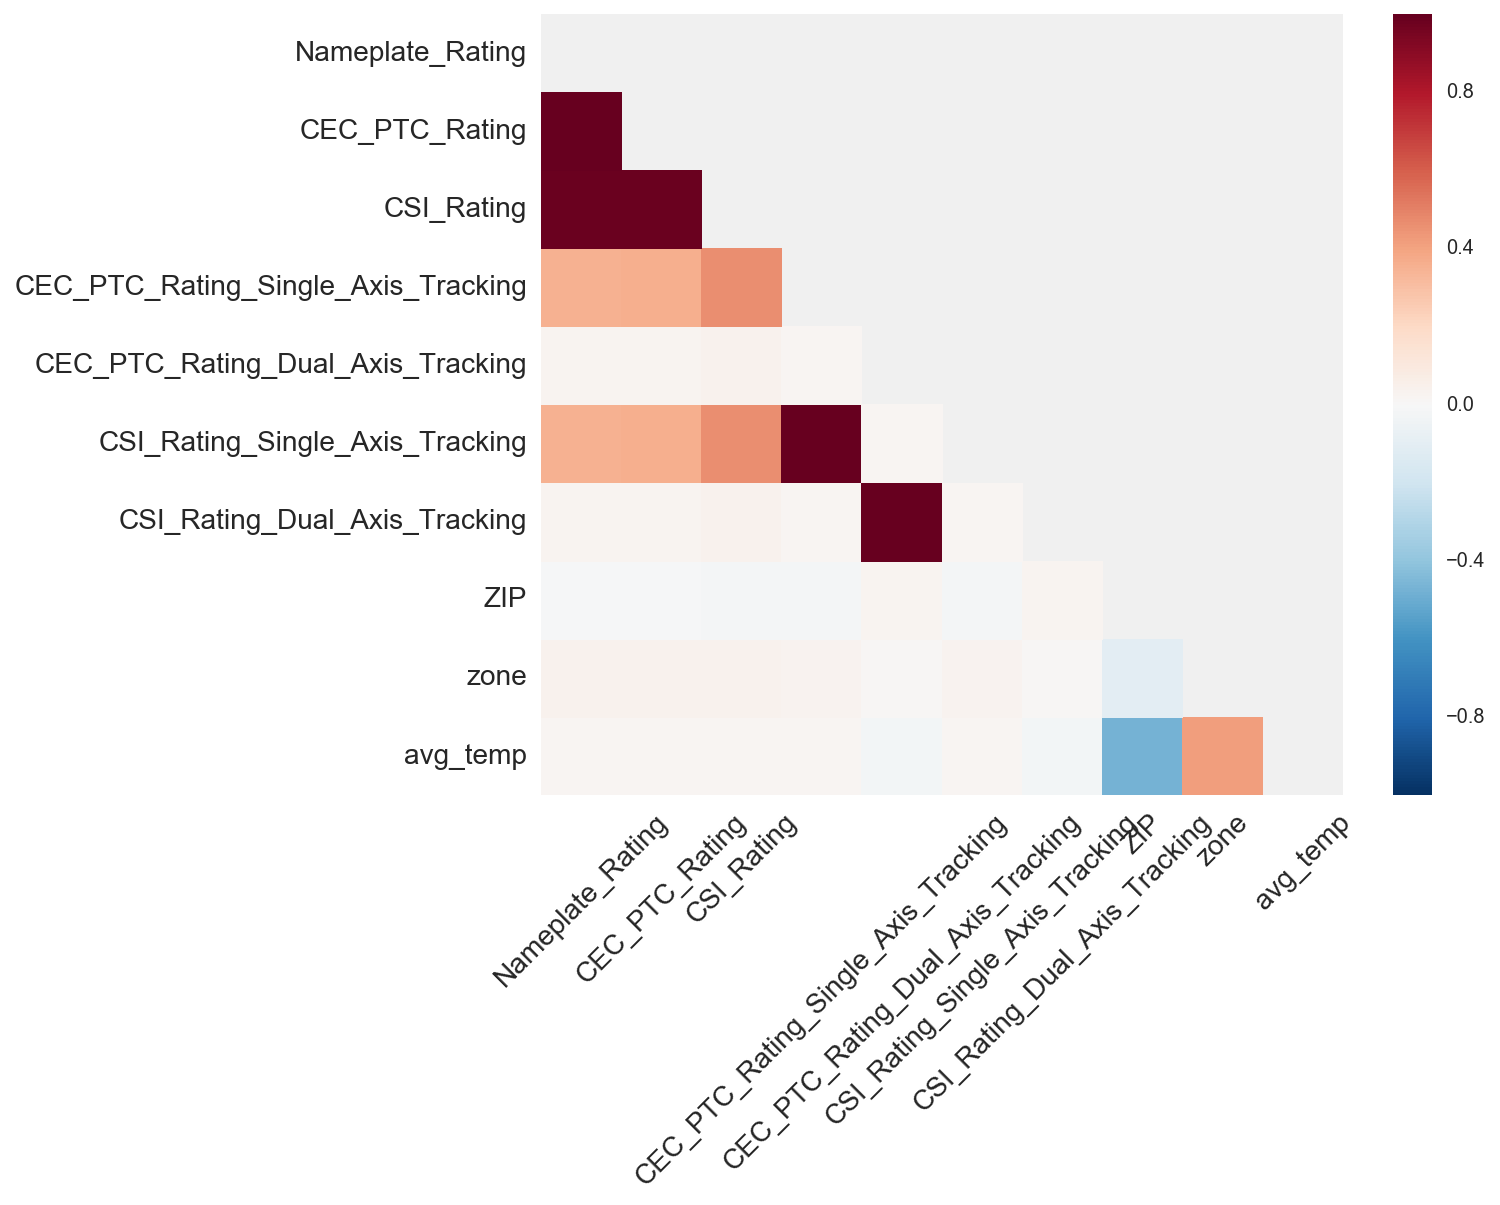

In [166]:
mask = np.zeros_like(ca_solar_df_num_corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

fig, ax = plt.subplots(figsize=(8,7))
ax = sns.heatmap(ca_solar_df_num_corr, mask=mask)

ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=14, rotation=45)
ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=14, rotation=0)

plt.show()

So interesting vars are Nameplate Rating, CEC PTC Rating, CSI Rating, zone, avg_temp

<h2> 4.1 Some linear regression on CA solar data now. </h2>

In [167]:
target1 = 'CEC_PTC_Rating'
target1 = 'CSI_Rating'
non_target_cols1 = ['Nameplate_Rating', 'CEC_PTC_Rating', 'CEC_PTC_Rating_Single_Axis_Tracking',
                   'CEC_PTC_Rating_Dual_Axis_Tracking', 'CSI_Rating_Single_Axis_Tracking', 
                    'CSI_Rating_Dual_Axis_Tracking', 'ZIP', 'zone', 'avg_temp']
formula_simple1 = target1 + ' ~ ' + ' + '.join(non_target_cols1) + ' -1'
print formula_simple1

CSI_Rating ~ Nameplate_Rating + CEC_PTC_Rating + CEC_PTC_Rating_Single_Axis_Tracking + CEC_PTC_Rating_Dual_Axis_Tracking + CSI_Rating_Single_Axis_Tracking + CSI_Rating_Dual_Axis_Tracking + ZIP + zone + avg_temp -1


In [168]:
ss1 = StandardScaler()
X1_n = ss.fit_transform(ca_solar_df_num)

In [169]:
Y1, X1 = patsy.dmatrices(formula_simple1, data=ca_solar_df_num)

In [170]:
X1_n.shape, Y1.shape

((4506, 10), (4506, 1))

In [171]:
linreg1 = LinearRegression()

linreg_scores1 = cross_val_score(linreg1, X1_n, Y1, cv=10)

print linreg_scores1
print np.mean(linreg_scores1)

[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
1.0


<h2> 4.2 Ridge regression with cross-validation. </h2>

In [172]:
ridge_alphas1 = np.logspace(0, 5, 200)

optimal_ridge1 = RidgeCV(alphas=ridge_alphas1, cv=10)
optimal_ridge1.fit(X1_n, Y1)

print optimal_ridge1.alpha_

1.0


In [173]:
ridge1 = Ridge(alpha=optimal_ridge1.alpha_)

ridge_scores1 = cross_val_score(ridge1, X1_n, Y1, cv=10)

print ridge_scores1
print np.mean(ridge_scores1)

[ 0.99997817  0.99998234  0.99998163  0.99994887  0.99998763  0.99995442
  0.99997168  0.99998497  0.99998466  0.99997479]
0.999974914889


<h2> 4.3 Try ElasticNet now. </h2>

In [174]:
enet_alphas1 = np.arange(0, 3.0, 0.05)
enet_coefs1 = elasticnet_coefs(X1, Y1, enet_alphas1)

/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/ipykernel/__main__.py:10: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator


In [175]:
simple_feature_names1 = X1.design_info.column_names

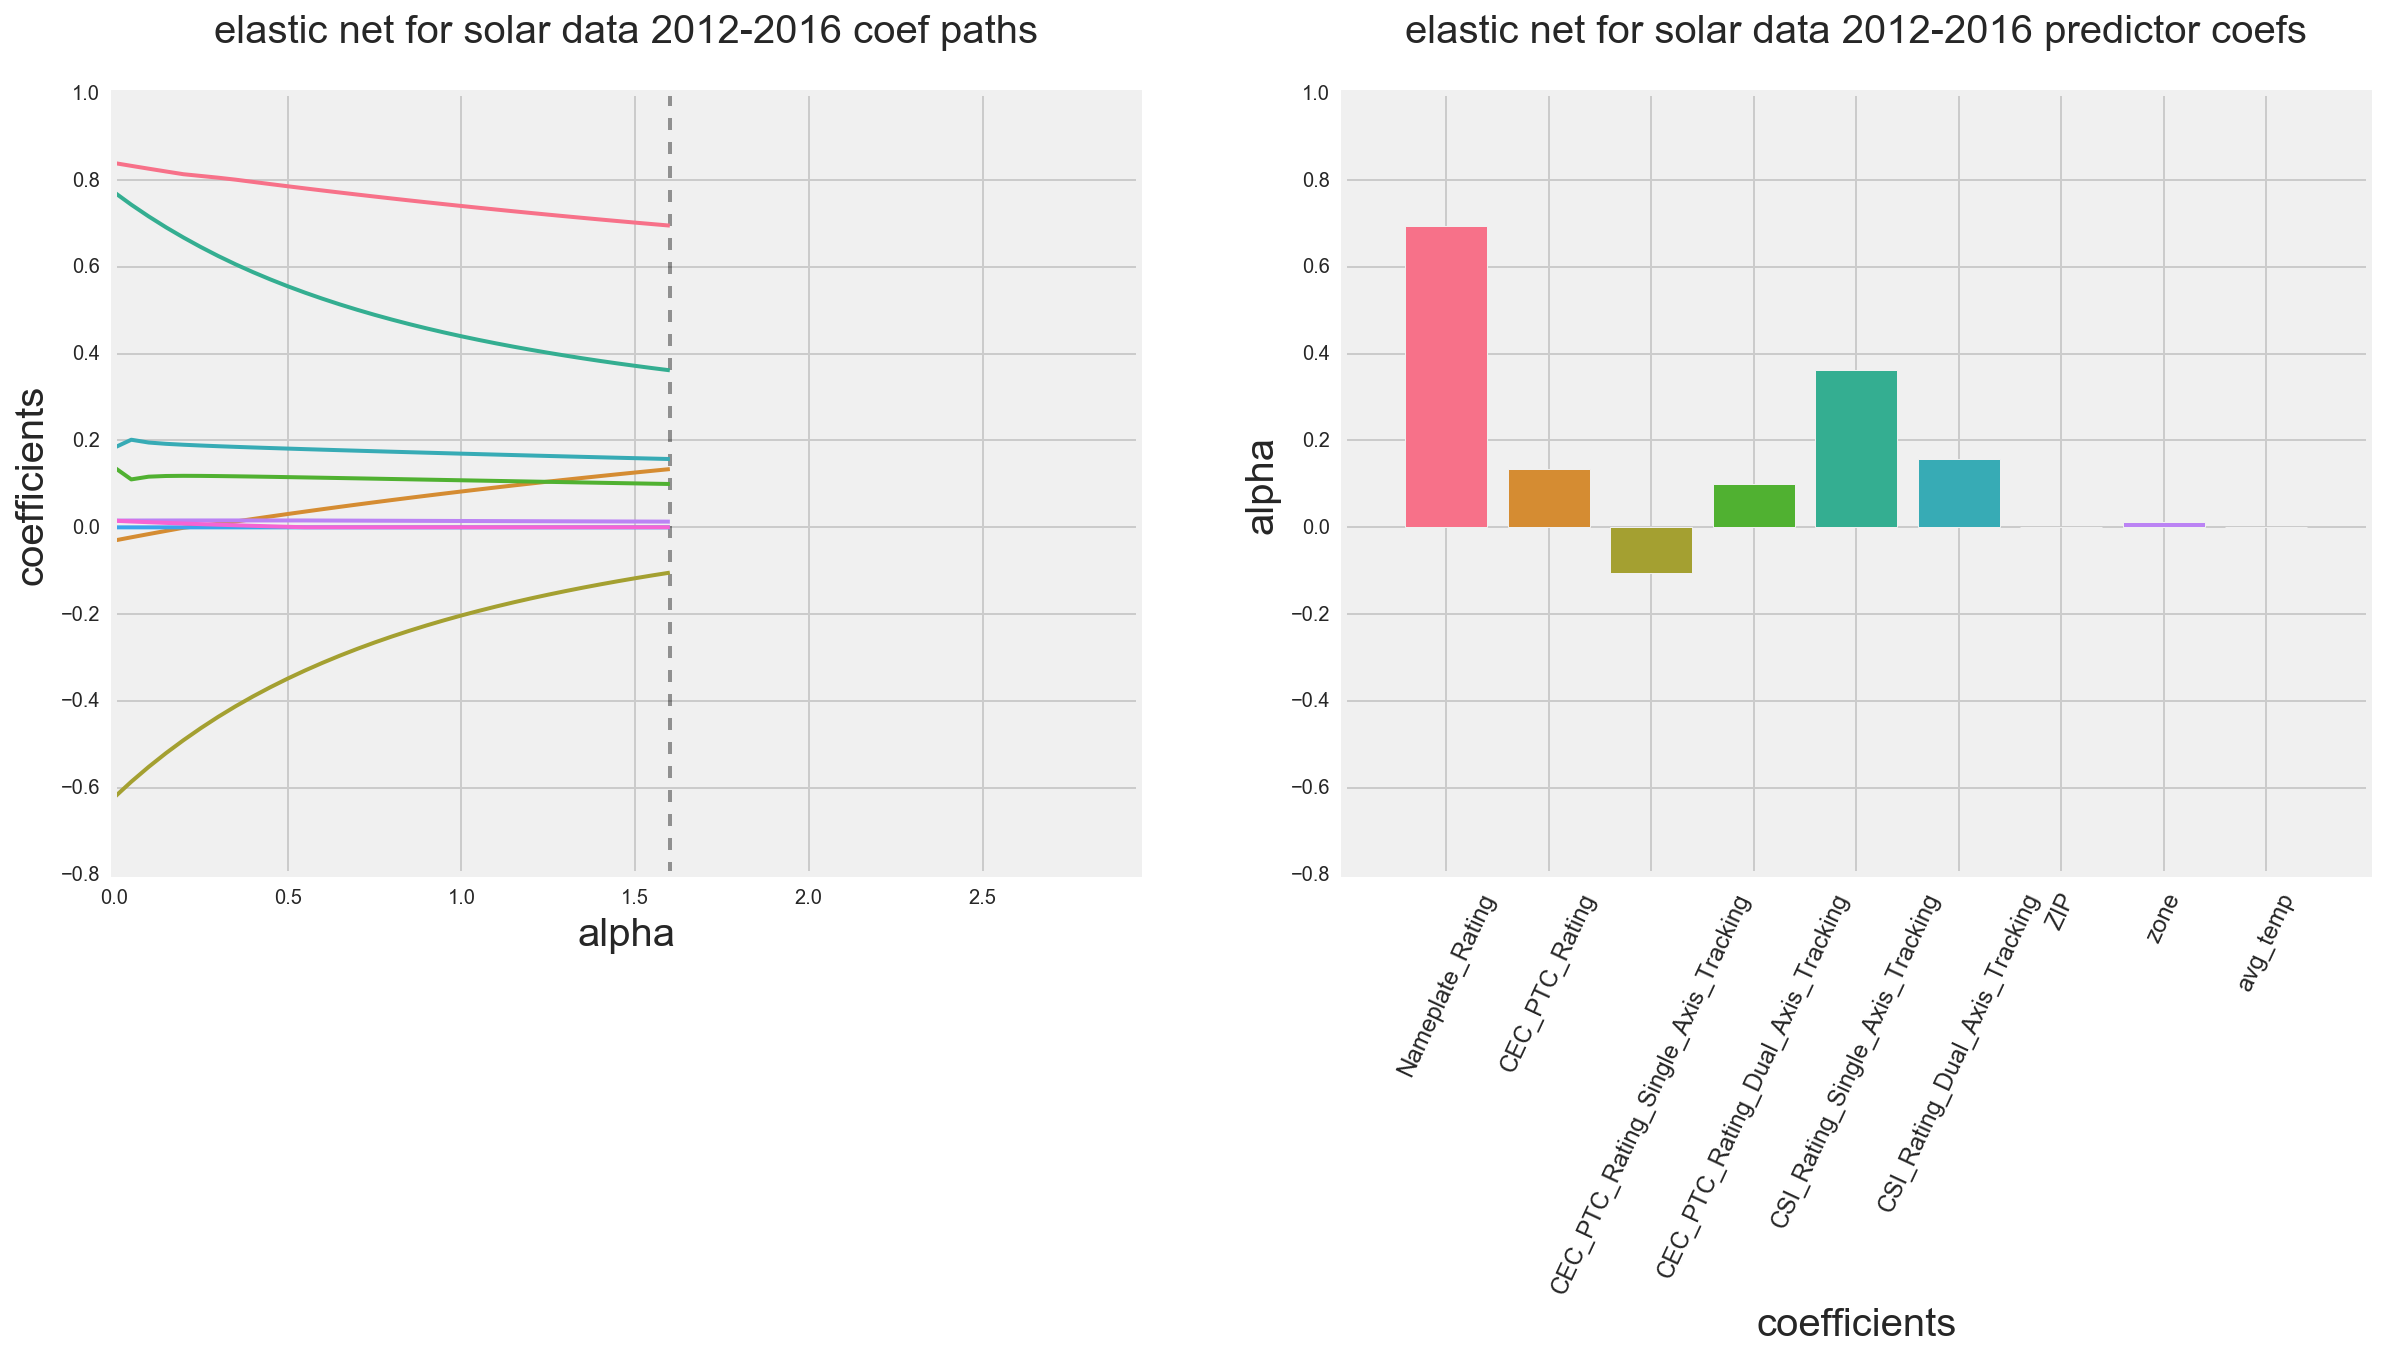

<function __main__.enet_plot_runner>

In [176]:
def enet_plot_runner(alpha=01.60):
    coef_plotter(enet_alphas1, enet_coefs1, simple_feature_names1, alpha, 
                 regtype='elastic net for solar data 2012-2016')

interact(enet_plot_runner, alpha=(0.0,3.0,0.05))

For CSI_Rating, we have correlation w Nameplate_Rating, CEC_PTC_Rating, CEC_PTC_Rating_Dual axis,, CSI Rating*, zone,
and anti-correlation w CEC_PTC rating single axis. 

<h2> 4.4 Stochastic Gradient Descent now. </h2>

In [177]:
sgd_params1 = {
    'loss':['squared_loss'],
    'penalty':['l1','l2'],
    'alpha':np.linspace(0.01, 10000, 100)
}

sgd_reg1 = SGDRegressor()
sgd_reg_gs1 = GridSearchCV(sgd_reg1, sgd_params1, cv=5, verbose=2)

In [178]:
sgd_reg_gs1.fit(X1_n, Y1)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
[CV] penalty=l1, alpha=0.01, loss=squared_loss .......................
[CV] .............. penalty=l1, alpha=0.01, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=0.01, loss=squared_loss .......................
[CV] .............. penalty=l1, alpha=0.01, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=0.01, loss=squared_loss .......................
[CV] .............. penalty=l1, alpha=0.01, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=0.01, loss=squared_loss .......................
[CV] .............. penalty=l1, alpha=0.01, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=0.01, loss=squared_loss .......................
[CV] .............. penalty=l1, alpha=0.01, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=0.01, loss=squared_loss .......................
[CV] .............. penalty=l2, alpha=0.01, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=0.01, loss=squared_loss .......................
[CV] ........

/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d arr

[CV] ............ penalty=l1, alpha=202.03, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=202.03, loss=squared_loss .....................
[CV] ............ penalty=l1, alpha=202.03, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=202.03, loss=squared_loss .....................
[CV] ............ penalty=l2, alpha=202.03, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=202.03, loss=squared_loss .....................
[CV] ............ penalty=l2, alpha=202.03, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=202.03, loss=squared_loss .....................
[CV] ............ penalty=l2, alpha=202.03, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=202.03, loss=squared_loss .....................
[CV] ............ penalty=l2, alpha=202.03, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=202.03, loss=squared_loss .....................
[CV] ............ penalty=l2, alpha=202.03, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=303.04, loss=squared_loss .....................
[CV] .

/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d arr

[CV] ............ penalty=l2, alpha=404.05, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=404.05, loss=squared_loss .....................
[CV] ............ penalty=l2, alpha=404.05, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=404.05, loss=squared_loss .....................
[CV] ............ penalty=l2, alpha=404.05, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=505.06, loss=squared_loss .....................
[CV] ............ penalty=l1, alpha=505.06, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=505.06, loss=squared_loss .....................
[CV] ............ penalty=l1, alpha=505.06, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=505.06, loss=squared_loss .....................
[CV] ............ penalty=l1, alpha=505.06, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=505.06, loss=squared_loss .....................
[CV] ............ penalty=l1, alpha=505.06, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=505.06, loss=squared_loss .....................
[CV] .

/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d arr

[CV] ............ penalty=l2, alpha=606.07, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=606.07, loss=squared_loss .....................
[CV] ............ penalty=l2, alpha=606.07, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=606.07, loss=squared_loss .....................
[CV] ............ penalty=l2, alpha=606.07, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=606.07, loss=squared_loss .....................
[CV] ............ penalty=l2, alpha=606.07, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=606.07, loss=squared_loss .....................
[CV] ............ penalty=l2, alpha=606.07, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=707.08, loss=squared_loss .....................
[CV] ............ penalty=l1, alpha=707.08, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=707.08, loss=squared_loss .....................
[CV] ............ penalty=l1, alpha=707.08, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=707.08, loss=squared_loss .....................
[CV] .

/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d arr

[CV] ............. penalty=l1, alpha=909.1, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=909.1, loss=squared_loss ......................
[CV] ............. penalty=l2, alpha=909.1, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=909.1, loss=squared_loss ......................
[CV] ............. penalty=l2, alpha=909.1, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=909.1, loss=squared_loss ......................
[CV] ............. penalty=l2, alpha=909.1, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=909.1, loss=squared_loss ......................
[CV] ............. penalty=l2, alpha=909.1, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=909.1, loss=squared_loss ......................
[CV] ............. penalty=l2, alpha=909.1, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=1010.11, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=1010.11, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=1010.11, loss=squared_loss ....................
[CV] .

/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d arr

[CV] ........... penalty=l1, alpha=1212.13, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=1212.13, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=1212.13, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=1212.13, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=1212.13, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=1212.13, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=1212.13, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=1212.13, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=1212.13, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=1212.13, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=1212.13, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=1212.13, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=1212.13, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=1212.13, loss=squared_loss ....................
[CV] .

/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d arr

[CV] ........... penalty=l2, alpha=1414.15, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=1414.15, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=1414.15, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=1414.15, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=1414.15, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=1414.15, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=1414.15, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=1414.15, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=1414.15, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=1515.16, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=1515.16, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=1515.16, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=1515.16, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=1515.16, loss=squared_loss ....................
[CV] .

/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d arr

[CV] ........... penalty=l2, alpha=1616.17, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=1717.18, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=1717.18, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=1717.18, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=1717.18, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=1717.18, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=1717.18, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=1717.18, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=1717.18, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=1717.18, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=1717.18, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=1717.18, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=1717.18, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=1717.18, loss=squared_loss ....................
[CV] .

/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d arr

[CV] ............ penalty=l1, alpha=1919.2, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=1919.2, loss=squared_loss .....................
[CV] ............ penalty=l1, alpha=1919.2, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=1919.2, loss=squared_loss .....................
[CV] ............ penalty=l1, alpha=1919.2, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=1919.2, loss=squared_loss .....................
[CV] ............ penalty=l1, alpha=1919.2, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=1919.2, loss=squared_loss .....................
[CV] ............ penalty=l1, alpha=1919.2, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=1919.2, loss=squared_loss .....................
[CV] ............ penalty=l2, alpha=1919.2, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=1919.2, loss=squared_loss .....................
[CV] ............ penalty=l2, alpha=1919.2, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=1919.2, loss=squared_loss .....................
[CV] .

/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d arr

[CV] ........... penalty=l1, alpha=2121.22, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=2121.22, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=2121.22, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=2121.22, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=2121.22, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=2121.22, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=2121.22, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=2121.22, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=2121.22, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=2121.22, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=2121.22, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=2121.22, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=2121.22, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=2121.22, loss=squared_loss ....................
[CV] .

/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d arr

[CV] ........... penalty=l1, alpha=2323.24, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=2323.24, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=2323.24, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=2323.24, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=2323.24, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=2323.24, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=2323.24, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=2323.24, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=2323.24, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=2323.24, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=2323.24, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=2323.24, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=2323.24, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=2424.25, loss=squared_loss ....................
[CV] .

/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d arr

[CV] ........... penalty=l2, alpha=2727.28, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=2727.28, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=2727.28, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=2727.28, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=2727.28, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=2727.28, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=2727.28, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=2727.28, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=2727.28, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=2828.29, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=2828.29, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=2828.29, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=2828.29, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=2828.29, loss=squared_loss ....................
[CV] .

/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d arr

[CV] ............ penalty=l2, alpha=2929.3, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=2929.3, loss=squared_loss .....................
[CV] ............ penalty=l2, alpha=2929.3, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=2929.3, loss=squared_loss .....................
[CV] ............ penalty=l2, alpha=2929.3, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=2929.3, loss=squared_loss .....................
[CV] ............ penalty=l2, alpha=2929.3, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=3030.31, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=3030.31, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=3030.31, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=3030.31, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=3030.31, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=3030.31, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=3030.31, loss=squared_loss ....................
[CV] .

/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d arr

[CV] penalty=l2, alpha=3131.32, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=3131.32, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=3131.32, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=3131.32, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=3232.33, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=3232.33, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=3232.33, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=3232.33, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=3232.33, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=3232.33, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=3232.33, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=3232.33, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=3232.33, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=3232.33, loss=squared_loss -   0.0s
[CV] p

/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d arr

[CV] ........... penalty=l2, alpha=3333.34, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=3333.34, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=3333.34, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=3434.35, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=3434.35, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=3434.35, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=3434.35, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=3434.35, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=3434.35, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=3434.35, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=3434.35, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=3434.35, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=3434.35, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=3434.35, loss=squared_loss ....................
[CV] .

/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d arr

[CV] ........... penalty=l1, alpha=3636.37, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=3636.37, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=3636.37, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=3636.37, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=3636.37, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=3636.37, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=3636.37, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=3636.37, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=3636.37, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=3636.37, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=3636.37, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=3636.37, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=3636.37, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=3636.37, loss=squared_loss ....................
[CV] .

/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d arr

[CV] ........... penalty=l1, alpha=3838.39, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=3838.39, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=3838.39, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=3838.39, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=3838.39, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=3838.39, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=3838.39, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=3838.39, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=3838.39, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=3838.39, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=3838.39, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=3838.39, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=3838.39, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=3838.39, loss=squared_loss ....................
[CV] .

/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d arr

[CV] ........... penalty=l1, alpha=4040.41, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=4040.41, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=4040.41, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=4040.41, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=4040.41, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=4040.41, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=4040.41, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=4040.41, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=4040.41, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=4040.41, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=4040.41, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=4141.42, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=4141.42, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=4141.42, loss=squared_loss ....................
[CV] .

/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d arr

[CV] ........... penalty=l2, alpha=4242.43, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=4242.43, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=4242.43, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=4242.43, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=4242.43, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=4343.44, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=4343.44, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=4343.44, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=4343.44, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=4343.44, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=4343.44, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=4343.44, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=4343.44, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=4343.44, loss=squared_loss ....................
[CV] .

/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d arr

[CV] ........... penalty=l1, alpha=4848.49, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=4848.49, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=4848.49, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=4848.49, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=4848.49, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=4848.49, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=4848.49, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=4848.49, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=4848.49, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=4848.49, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=4848.49, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=4848.49, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=4848.49, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=4848.49, loss=squared_loss ....................
[CV] .

/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d arr

[CV] ........... penalty=l1, alpha=5050.51, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=5050.51, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=5050.51, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=5050.51, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=5050.51, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=5050.51, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=5050.51, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=5050.51, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=5050.51, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=5050.51, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=5050.51, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=5050.51, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=5050.51, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=5151.52, loss=squared_loss ....................
[CV] .

/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d arr

[CV] ........... penalty=l2, alpha=5252.53, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=5353.54, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=5353.54, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=5353.54, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=5353.54, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=5353.54, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=5353.54, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=5353.54, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=5353.54, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=5353.54, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=5353.54, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=5353.54, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=5353.54, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=5353.54, loss=squared_loss ....................
[CV] .

/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d arr

[CV] ........... penalty=l2, alpha=5555.56, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=5555.56, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=5555.56, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=5555.56, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=5555.56, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=5555.56, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=5555.56, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=5555.56, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=5555.56, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=5656.57, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=5656.57, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=5656.57, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=5656.57, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=5656.57, loss=squared_loss ....................
[CV] .

/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d arr

[CV] ........... penalty=l1, alpha=5858.59, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=5858.59, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=5858.59, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=5858.59, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=5858.59, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=5858.59, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=5858.59, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=5858.59, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=5858.59, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=5858.59, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=5858.59, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=5858.59, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=5858.59, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=5858.59, loss=squared_loss ....................
[CV] .

/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d arr

[CV] ........... penalty=l2, alpha=6060.61, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=6060.61, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=6060.61, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=6060.61, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=6060.61, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=6161.62, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=6161.62, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=6161.62, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=6161.62, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=6161.62, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=6161.62, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=6161.62, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=6161.62, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=6161.62, loss=squared_loss ....................
[CV] .

/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d arr

[CV] ........... penalty=l2, alpha=6262.63, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=6262.63, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=6262.63, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=6363.64, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=6363.64, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=6363.64, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=6363.64, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=6363.64, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=6363.64, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=6363.64, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=6363.64, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=6363.64, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=6363.64, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=6363.64, loss=squared_loss ....................
[CV] .

/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d arr

[CV] ........... penalty=l1, alpha=6565.66, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=6565.66, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=6565.66, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=6565.66, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=6565.66, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=6565.66, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=6565.66, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=6565.66, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=6565.66, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=6565.66, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=6565.66, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=6565.66, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=6565.66, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=6565.66, loss=squared_loss ....................
[CV] .

/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d arr

[CV] penalty=l2, alpha=6767.68, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=6767.68, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=6767.68, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=6767.68, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=6868.69, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=6868.69, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=6868.69, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=6868.69, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=6868.69, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=6868.69, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=6868.69, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=6868.69, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=6868.69, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=6868.69, loss=squared_loss -   0.0s
[CV] p

/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d arr

[CV] ........... penalty=l1, alpha=7070.71, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=7070.71, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=7070.71, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=7070.71, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=7070.71, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=7070.71, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=7070.71, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=7070.71, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=7070.71, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=7070.71, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=7070.71, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=7070.71, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=7070.71, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=7070.71, loss=squared_loss ....................
[CV] .

/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d arr

[CV] ........... penalty=l2, alpha=7272.73, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=7272.73, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=7272.73, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=7272.73, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=7272.73, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=7272.73, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=7272.73, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=7272.73, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=7272.73, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=7373.74, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=7373.74, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=7373.74, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=7373.74, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=7373.74, loss=squared_loss ....................
[CV] .

/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d arr

[CV] ........... penalty=l2, alpha=7373.74, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=7373.74, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=7373.74, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=7474.75, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=7474.75, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=7474.75, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=7474.75, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=7474.75, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=7474.75, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=7474.75, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=7474.75, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=7474.75, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=7474.75, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=7474.75, loss=squared_loss ....................
[CV] .

/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d arr

[CV] ........... penalty=l1, alpha=7676.77, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=7676.77, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=7676.77, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=7676.77, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=7676.77, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=7676.77, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=7676.77, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=7676.77, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=7676.77, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=7676.77, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=7676.77, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=7676.77, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=7676.77, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=7676.77, loss=squared_loss ....................
[CV] .

/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d arr

[CV] ........... penalty=l2, alpha=7878.79, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=7878.79, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=7878.79, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=7979.8, loss=squared_loss .....................
[CV] ............ penalty=l1, alpha=7979.8, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=7979.8, loss=squared_loss .....................
[CV] ............ penalty=l1, alpha=7979.8, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=7979.8, loss=squared_loss .....................
[CV] ............ penalty=l1, alpha=7979.8, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=7979.8, loss=squared_loss .....................
[CV] ............ penalty=l1, alpha=7979.8, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=7979.8, loss=squared_loss .....................
[CV] ............ penalty=l1, alpha=7979.8, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=7979.8, loss=squared_loss .....................
[CV] .

/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d arr

[CV] ........... penalty=l1, alpha=8181.82, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=8181.82, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=8181.82, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=8181.82, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=8181.82, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=8181.82, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=8181.82, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=8181.82, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=8181.82, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=8181.82, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=8181.82, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=8282.83, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=8282.83, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=8282.83, loss=squared_loss ....................
[CV] .

/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d arr

[CV] ........... penalty=l2, alpha=8383.84, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=8383.84, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=8383.84, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=8383.84, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=8383.84, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=8383.84, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=8383.84, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=8484.85, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=8484.85, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=8484.85, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=8484.85, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=8484.85, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=8484.85, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=8484.85, loss=squared_loss ....................
[CV] .

/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d arr

[CV] ........... penalty=l1, alpha=8686.87, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=8686.87, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=8686.87, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=8686.87, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=8686.87, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=8686.87, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=8686.87, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=8686.87, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=8686.87, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=8686.87, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=8686.87, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=8686.87, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=8686.87, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=8686.87, loss=squared_loss ....................
[CV] .

/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d arr

[CV] ........... penalty=l2, alpha=8888.89, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=8888.89, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=8888.89, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=8888.89, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=8888.89, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=8888.89, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=8888.89, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=8989.9, loss=squared_loss .....................
[CV] ............ penalty=l1, alpha=8989.9, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=8989.9, loss=squared_loss .....................
[CV] ............ penalty=l1, alpha=8989.9, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=8989.9, loss=squared_loss .....................
[CV] ............ penalty=l1, alpha=8989.9, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=8989.9, loss=squared_loss .....................
[CV] .

/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d arr

[CV] ........... penalty=l1, alpha=9191.92, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=9191.92, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=9191.92, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=9191.92, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=9191.92, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=9191.92, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=9191.92, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=9191.92, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=9191.92, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=9191.92, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=9191.92, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=9191.92, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=9191.92, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=9191.92, loss=squared_loss ....................
[CV] .

/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d arr

[CV] penalty=l1, alpha=9393.94, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=9393.94, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=9393.94, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=9393.94, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=9393.94, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=9393.94, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=9393.94, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=9393.94, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=9393.94, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=9393.94, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=9393.94, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=9393.94, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=9393.94, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=9393.94, loss=squared_loss -   0.0s
[CV] p

/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d arr

[CV] ........... penalty=l2, alpha=9595.96, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=9595.96, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=9595.96, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=9595.96, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=9595.96, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=9595.96, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=9595.96, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=9595.96, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=9595.96, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=9696.97, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=9696.97, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=9696.97, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=9696.97, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=9696.97, loss=squared_loss ....................
[CV] .

/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d arr

[CV] ........... penalty=l1, alpha=9898.99, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=9898.99, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=9898.99, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=9898.99, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=9898.99, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=9898.99, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=9898.99, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=9898.99, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=9898.99, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=9898.99, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=9898.99, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=9898.99, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=9898.99, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=9898.99, loss=squared_loss ....................
[CV] .

/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d arr

GridSearchCV(cv=5, error_score='raise',
       estimator=SGDRegressor(alpha=0.0001, average=False, epsilon=0.1, eta0=0.01,
       fit_intercept=True, l1_ratio=0.15, learning_rate='invscaling',
       loss='squared_loss', n_iter=5, penalty='l2', power_t=0.25,
       random_state=None, shuffle=True, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'penalty': ['l1', 'l2'], 'loss': ['squared_loss'], 'alpha': array([  1.00000e-02,   1.01020e+02, ...,   9.89899e+03,   1.00000e+04])},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=2)

In [179]:
print sgd_reg_gs1.best_params_
print sgd_reg_gs1.best_score_
sgd_reg1 = sgd_reg_gs1.best_estimator_

{'penalty': 'l2', 'alpha': 2828.29, 'loss': 'squared_loss'}
0.16929846101


Not as good as for PGE data. Maybe more data might help.

<h2> 4.5 Let's also try time series analysis here, since the data covers 2012-2016 also. </h2>

In [180]:
ca_nameplate_diff = ca_solar_df_num.Nameplate_Rating.diff()

In [181]:
ca_nameplate_diff.dropna(inplace=True)

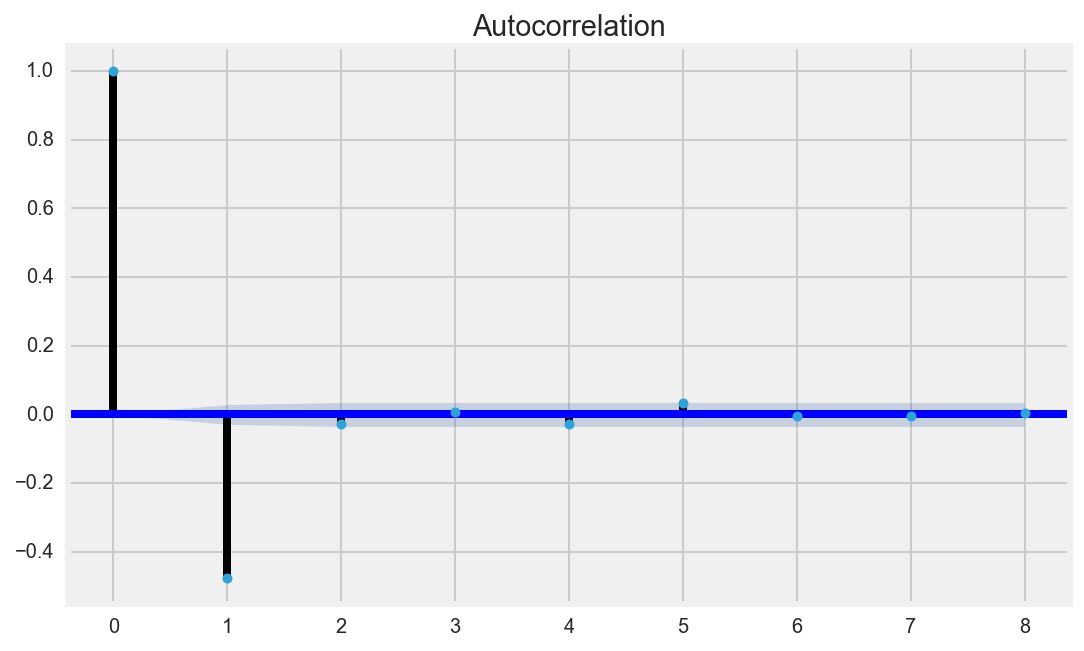

In [182]:
fig = plt.figure(figsize=(8,5))
ax = fig.gca()
plot_acf(ca_nameplate_diff, lags=8, ax=ax)
plt.show()

In [183]:
ar3 = ARMA(ca_nameplate_diff.values, (1,0)).fit()
ar3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                 4505
Model:                     ARMA(1, 0)   Log Likelihood              -26645.934
Method:                       css-mle   S.D. of innovations             89.638
Date:                Fri, 30 Sep 2016   AIC                          53297.869
Time:                        16:38:52   BIC                          53317.108
Sample:                             0   HQIC                         53304.648
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          0.0005      0.904      0.001      1.000        -1.772     1.773
ar.L1.y       -0.4768      0.013    -36.413      0.000        -0.502    -0.451
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -2.0974           +0.0000j            2.0974            0.5000
-----------------------------------------------------------------------------
"""

In [184]:
r2_score(ca_nameplate_diff, ar3.fittedvalues)

0.22741276481933803

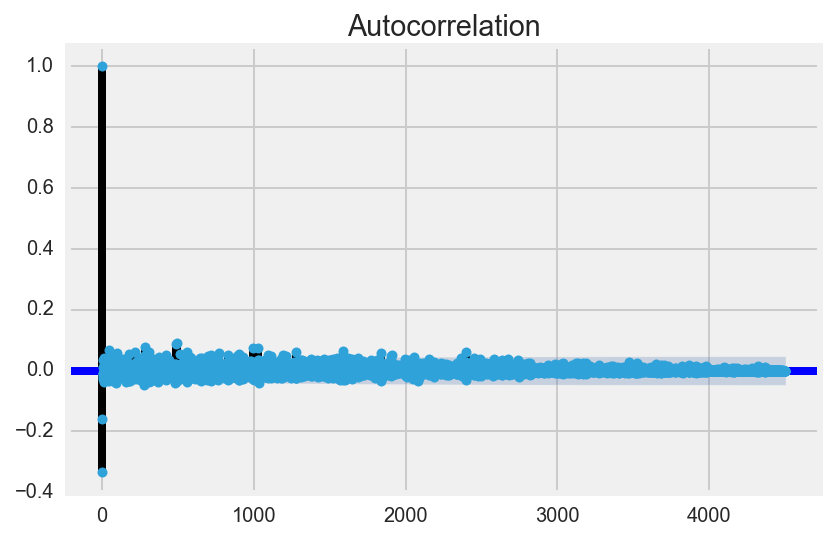

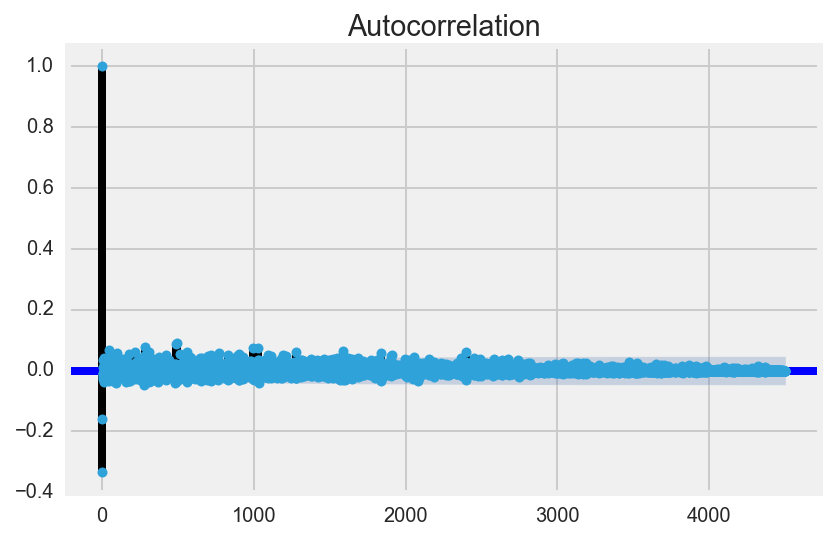

In [185]:
plot_acf(ar3.resid)

Likewise, the auto-correlation plot seems OK, so we can trust the time series analysis. 

<h2> 5. Let's merge now the PGE data w the solar data, see if we can learn anything from that. </h2>

In [186]:
pge_q_num.head(3)

,ZipCode,Month,Year,CustomerClass,Combined,TotalCustomers,TotalkWh,AveragekWh,zone,avg_temp
4011,95329,2,2012,2,1,1047.0,654735.0,625.0,12.0,57.166667
6132,94572,6,2016,2,1,2741.0,1359822.0,496.0,3.0,55.000000
2977,93906,2,2012,1,1,503.0,3957274.0,7867.0,3.0,55.000000


In [187]:
ca_solar_df_num.head(3)

,Nameplate_Rating,CEC_PTC_Rating,CSI_Rating,CEC_PTC_Rating_Single_Axis_Tracking,CEC_PTC_Rating_Dual_Axis_Tracking,CSI_Rating_Single_Axis_Tracking,CSI_Rating_Dual_Axis_Tracking,ZIP,zone,avg_temp
12297,2.820,2.413,2.350,0.0,0.0,0.0,0.0,93950,3.0,55.000000
37044,5.075,4.339,3.603,0.0,0.0,0.0,0.0,95060,3.0,55.000000
10,7.750,6.791,6.479,0.0,0.0,0.0,0.0,93311,13.0,58.166667


In [321]:
ca_solar_df_num.iloc[2,7]

93311.0

In [322]:
zip_to_nameplate_dict = {}
for zip in range(0,ca_solar_df_num.shape[0]):
    zip_val = ca_solar_df_num.iloc[zip, 7]
    kwh_val = ca_solar_df_num.iloc[zip, 0]
    zip_to_nameplate_dict[zip_val]  = kwh_val

In [323]:
pge_q_num['nameplate']  =  -1.0 * pge_q_num['ZipCode'].map(zip_to_nameplate_dict)

In [324]:
pge_q_num.dropna(inplace=True)

In [326]:
zip_to_cec_dict = {}
for zip in range(0,ca_solar_df_num.shape[0]):
    zip_val = ca_solar_df_num.iloc[zip, 7]
    kwh_val = ca_solar_df_num.iloc[zip, 1]
    zip_to_cec_dict[zip_val]  = kwh_val

In [327]:
pge_q_num['cec']  =  -1.0 * pge_q_num['ZipCode'].map(zip_to_cec_dict)

In [328]:
pge_q_num.dropna(inplace=True)

In [329]:
zip_to_csi_dict = {}
for zip in range(0,ca_solar_df_num.shape[0]):
    zip_val = ca_solar_df_num.iloc[zip, 7]
    kwh_val = ca_solar_df_num.iloc[zip, 2]
    zip_to_csi_dict[zip_val]  = kwh_val

In [330]:
pge_q_num['csi']  =  -1.0 * pge_q_num['ZipCode'].map(zip_to_csi_dict)

In [331]:
pge_q_num.dropna(inplace=True)

In [332]:
zip_to_cec_1_tracking_dict = {}
for zip in range(0,ca_solar_df_num.shape[0]):
    zip_val = ca_solar_df_num.iloc[zip, 7]
    kwh_val = ca_solar_df_num.iloc[zip, 3]
    zip_to_cec_1_tracking_dict[zip_val]  = kwh_val

In [333]:
pge_q_num['cec_1_track']  =  -1.0 * pge_q_num['ZipCode'].map(zip_to_cec_1_tracking_dict)

In [334]:
pge_q_num.dropna(inplace=True)

In [335]:
zip_to_cec_2_tracking_dict = {}
for zip in range(0,ca_solar_df_num.shape[0]):
    zip_val = ca_solar_df_num.iloc[zip, 7]
    kwh_val = ca_solar_df_num.iloc[zip, 4]
    zip_to_cec_2_tracking_dict[zip_val]  = kwh_val

In [336]:
pge_q_num['cec_2_track']  =  -1.0 * pge_q_num['ZipCode'].map(zip_to_cec_2_tracking_dict)

In [337]:
pge_q_num.dropna(inplace=True)

In [338]:
zip_to_csi_1_tracking_dict = {}
for zip in range(0,ca_solar_df_num.shape[0]):
    zip_val = ca_solar_df_num.iloc[zip, 7]
    kwh_val = ca_solar_df_num.iloc[zip, 5]
    zip_to_csi_1_tracking_dict[zip_val]  = kwh_val

In [339]:
pge_q_num['csi_1_track']  =  -1.0 * pge_q_num['ZipCode'].map(zip_to_csi_1_tracking_dict)

In [340]:
pge_q_num.dropna(inplace=True)

In [341]:
zip_to_csi_2_tracking_dict = {}
for zip in range(0,ca_solar_df_num.shape[0]):
    zip_val = ca_solar_df_num.iloc[zip, 7]
    kwh_val = ca_solar_df_num.iloc[zip, 6]
    zip_to_csi_2_tracking_dict[zip_val]  = kwh_val

In [342]:
pge_q_num['csi_2_track']  =  -1.0 * pge_q_num['ZipCode'].map(zip_to_csi_2_tracking_dict)

In [343]:
pge_q_num.dropna(inplace=True)

In [344]:
pge_q_num.head(3)

,ZipCode,Month,Year,CustomerClass,Combined,TotalCustomers,TotalkWh,AveragekWh,zone,avg_temp,nameplate,cec,csi,cec_1_track,cec_2_track,csi_1_track,csi_2_track
4793,95973,2,2012,2,1,11431.0,6478558.0,567.0,11.0,53.500000,-4.32,-3.748,-3.311,-0.0,-0.0,-0.0,-0.0
5887,94123,3,2016,1,1,897.0,2674098.0,2981.0,3.0,55.000000,-1.92,-1.676,-1.607,-0.0,-0.0,-0.0,-0.0
53,93241,1,2015,2,1,3397.0,1757876.0,517.0,13.0,58.166667,-1142.40,-1001.064,-999.112,-0.0,-0.0,-0.0,-0.0


In [345]:
pge_q_num_corr1 = pge_q_num.corr()

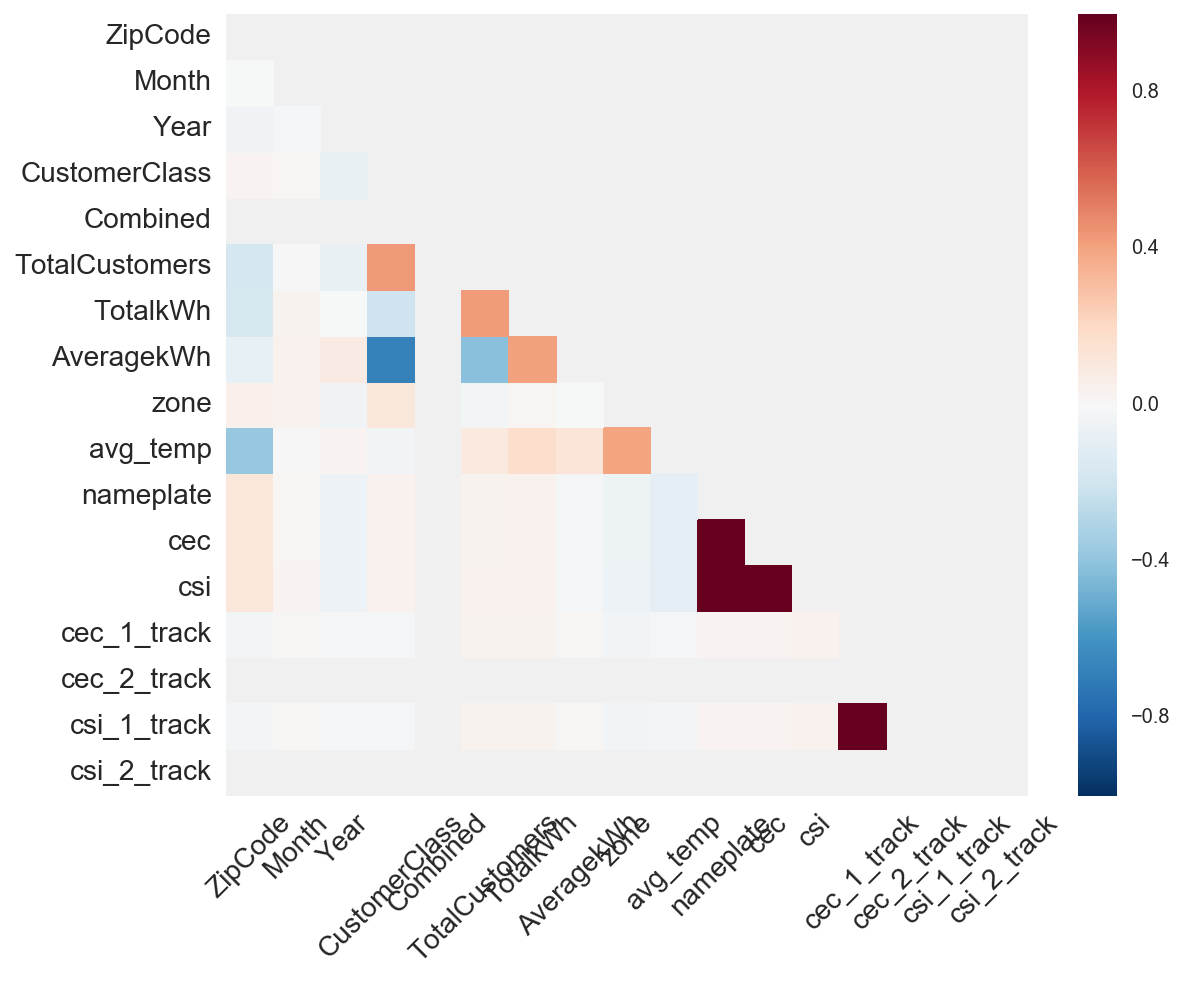

In [346]:
mask = np.zeros_like(pge_q_num_corr1, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

fig, ax = plt.subplots(figsize=(8,7))
ax = sns.heatmap(pge_q_num_corr1, mask=mask)

ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=14, rotation=45)
ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=14, rotation=0)

plt.show()

<h2> 5.1  Let's see if there is any correlation between TotalkWh (aPGE datum) 
and nameplate (a solar datum) by zone. </h2>

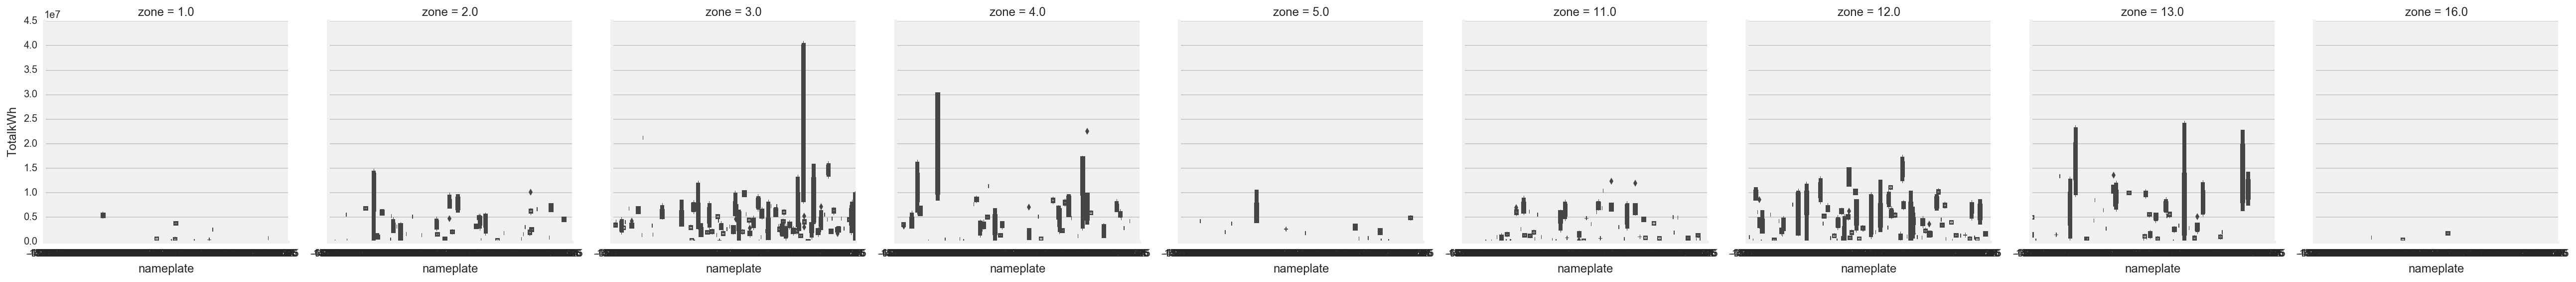

In [347]:
#sns.factorplot(x='Month', y='TotalkWh',col='Year', kind='box', data=pge_q_num)
sns.factorplot(x='nameplate', y='TotalkWh',col='zone', kind='box', data=pge_q_num)

<h2> 5.2 Let's do now some Linear Regression. That is always the first thing... </h2>

In [348]:
target2 = 'TotalkWh'
non_target_cols2 = ['AveragekWh', 'CustomerClass', 'TotalCustomers', 'ZipCode', 'zone', 'nameplate', 'cec', 'csi' ,
                   'cec_1_track', 'cec_2_track', 'csi_1_track', 'csi_2_track', 'avg_temp']
formula_simple2 = target2 + ' ~ ' + ' + '.join(non_target_cols2) + ' -1'
print formula_simple2

TotalkWh ~ AveragekWh + CustomerClass + TotalCustomers + ZipCode + zone + nameplate + cec + csi + cec_1_track + cec_2_track + csi_1_track + csi_2_track + avg_temp -1


In [349]:
Y2, X2 = patsy.dmatrices(formula_simple2, data=pge_q_num)

In [350]:
simple_feature_names2 = X2.design_info.column_names

In [351]:
X2_n = ss.fit_transform(pge_q_num)

In [352]:
linreg2 = LinearRegression()

linreg_scores2 = cross_val_score(linreg2, X2_n, Y2, cv=10)

print linreg_scores2
print np.mean(linreg_scores2)

[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
1.0


<h2> 5.3 And now some Ridge Regression.  </h2> 

In [353]:
ridge_alphas2 = np.logspace(0, 5, 200)

optimal_ridge2 = RidgeCV(alphas=ridge_alphas2, cv=10)
optimal_ridge2.fit(X2_n, Y2)

print optimal_ridge2.alpha_

1.0


<h2> 5.4 Then some LassoCV for cross-validation.  </h2>

In [354]:
optimal_lasso2 = LassoCV(n_alphas=500, cv=10, verbose=1)
optimal_lasso2.fit(X2_n, Y2)

print optimal_lasso2.alpha_

/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:1051: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
...............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

4474.43963161


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.6s finished


In [355]:
lasso2 = Lasso(alpha=optimal_lasso2.alpha_)

lasso_scores2 = cross_val_score(lasso2, X2_n, Y2, cv=10)

print lasso_scores2
print np.mean(lasso_scores2)

[ 0.99999906  0.9999989   0.99999863  0.99999907  0.99999907  0.9999991
  0.99999907  0.99999899  0.99999899  0.99999864]
0.999998950663


<h2> 5.5. Finally, ElasticNet to get the optimal value. </h2>

In [356]:
enet_alphas2 = np.arange(0, 3.0, 0.05)
enet_coefs2 = elasticnet_coefs(X2, Y2, enet_alphas2)

/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/ipykernel/__main__.py:10: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator


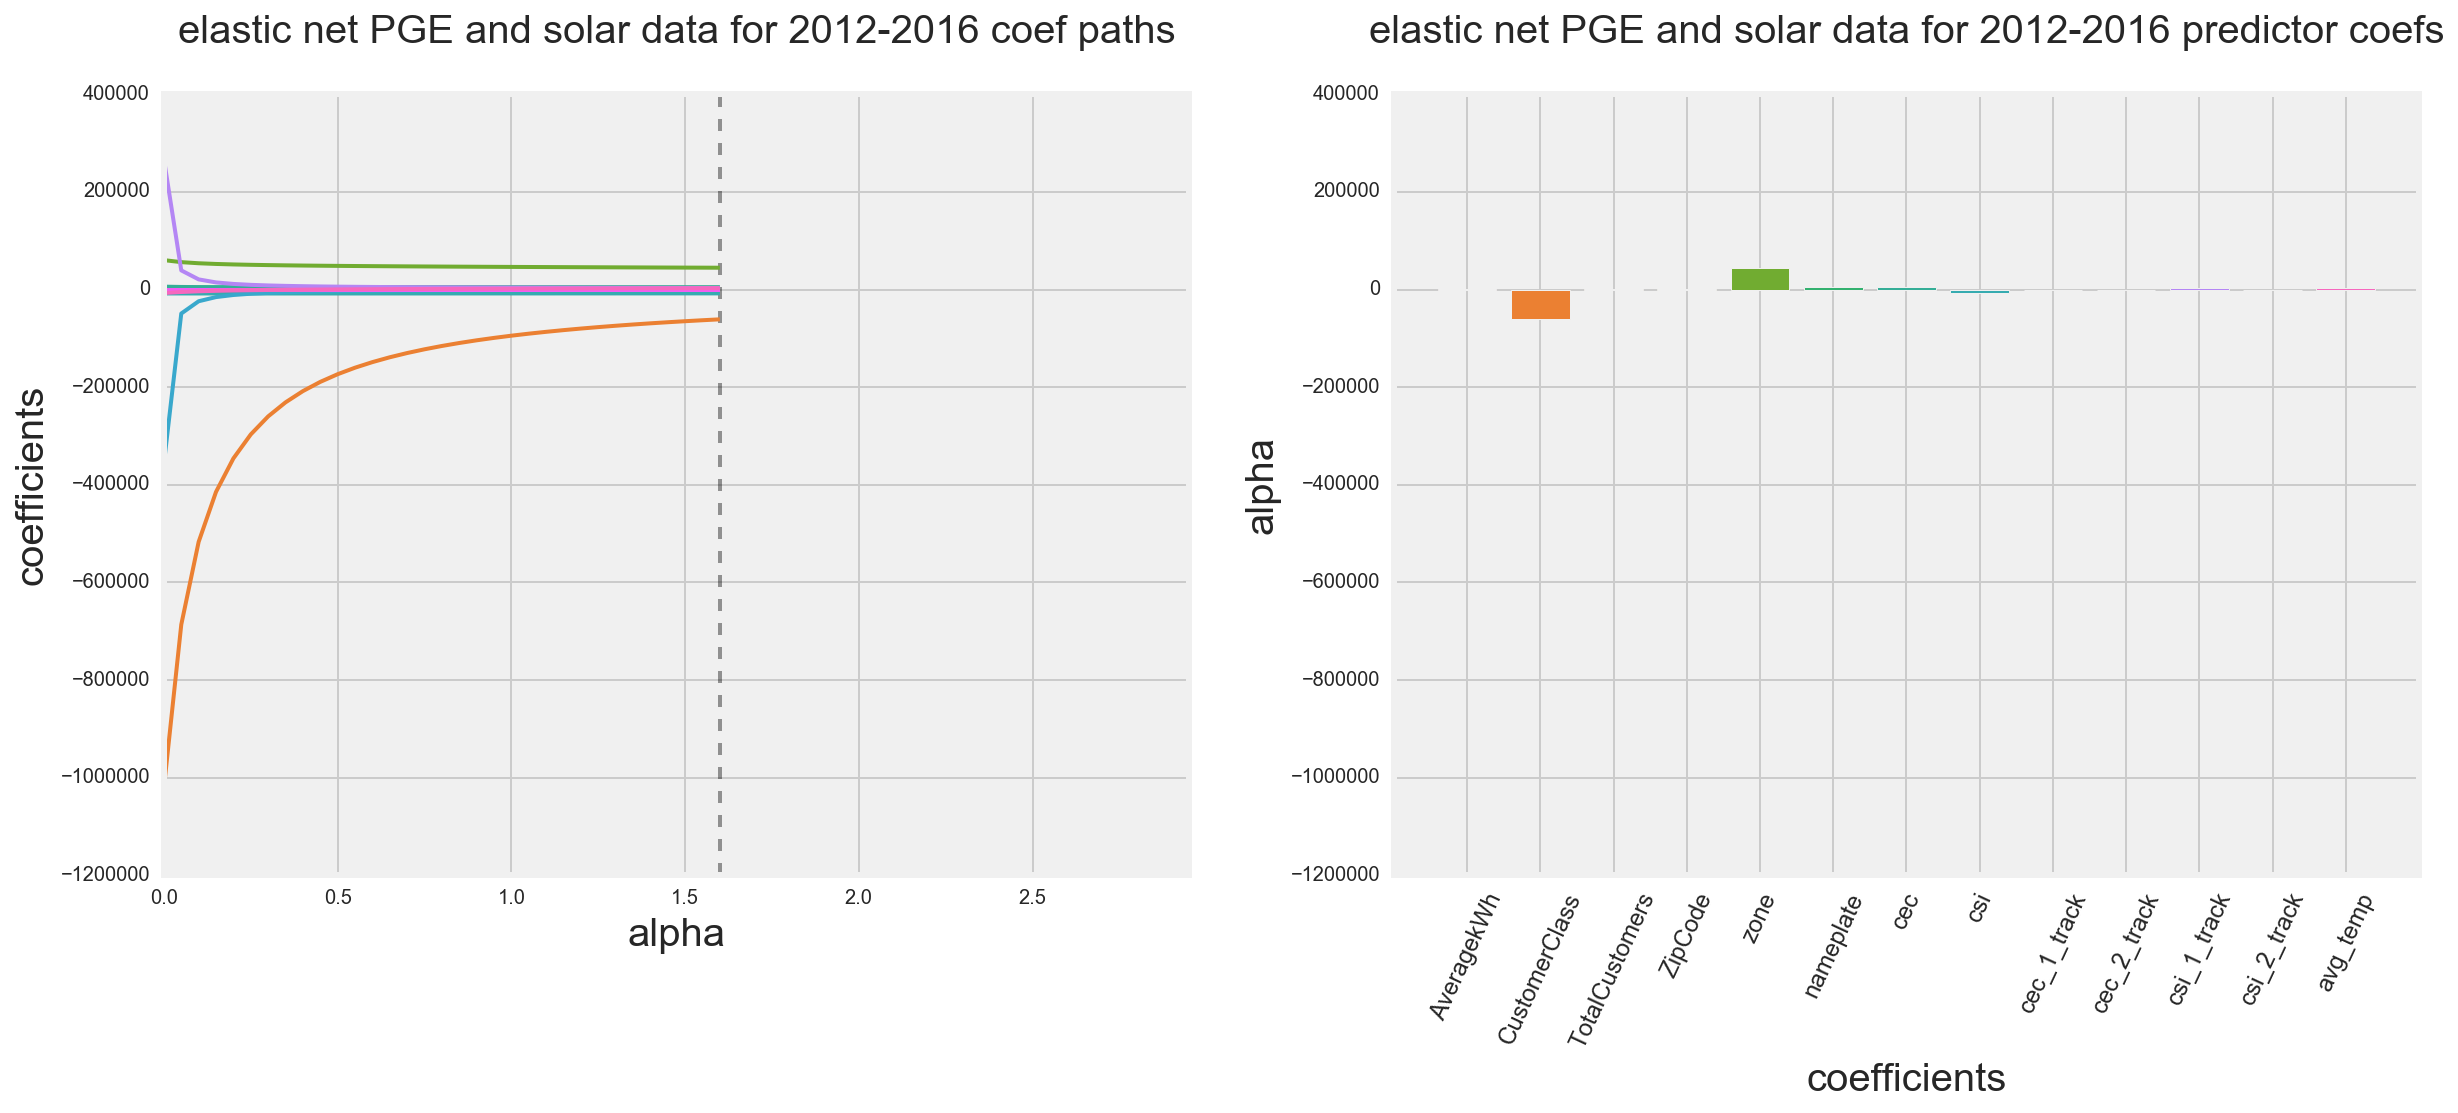

<function __main__.enet_plot_runner>

In [357]:
def enet_plot_runner(alpha=01.6):
    coef_plotter(enet_alphas2, enet_coefs2, simple_feature_names2, alpha, 
                 regtype='elastic net PGE and solar data for 2012-2016')

interact(enet_plot_runner, alpha=(0.0,3.0,0.05))

<h2> 5.6 And now some SGD. </h2>

In [358]:
sgd_params2 = {
    'loss':['squared_loss'],
    'penalty':['l1','l2'],
    'alpha':np.linspace(0.01, 10000, 100)
}

sgd_reg2 = SGDRegressor()
sgd_reg_gs2 = GridSearchCV(sgd_reg2, sgd_params2, cv=5, verbose=2)

In [359]:
sgd_reg_gs2.fit(X2_n, Y2)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
[CV] penalty=l1, alpha=0.01, loss=squared_loss .......................
[CV] .............. penalty=l1, alpha=0.01, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=0.01, loss=squared_loss .......................
[CV] .............. penalty=l1, alpha=0.01, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=0.01, loss=squared_loss .......................
[CV] .............. penalty=l1, alpha=0.01, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=0.01, loss=squared_loss .......................
[CV] .............. penalty=l1, alpha=0.01, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=0.01, loss=squared_loss .......................
[CV] .............. penalty=l1, alpha=0.01, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=0.01, loss=squared_loss .......................
[CV] .............. penalty=l2, alpha=0.01, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=0.01, loss=squared_loss .......................
[CV] ........

/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d arr

[CV] ............ penalty=l1, alpha=404.05, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=404.05, loss=squared_loss .....................
[CV] ............ penalty=l1, alpha=404.05, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=404.05, loss=squared_loss .....................
[CV] ............ penalty=l1, alpha=404.05, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=404.05, loss=squared_loss .....................
[CV] ............ penalty=l1, alpha=404.05, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=404.05, loss=squared_loss .....................
[CV] ............ penalty=l2, alpha=404.05, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=404.05, loss=squared_loss .....................
[CV] ............ penalty=l2, alpha=404.05, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=404.05, loss=squared_loss .....................
[CV] ............ penalty=l2, alpha=404.05, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=404.05, loss=squared_loss .....................
[CV] .

/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d arr

[CV] ............ penalty=l1, alpha=808.09, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=808.09, loss=squared_loss .....................
[CV] ............ penalty=l1, alpha=808.09, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=808.09, loss=squared_loss .....................
[CV] ............ penalty=l2, alpha=808.09, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=808.09, loss=squared_loss .....................
[CV] ............ penalty=l2, alpha=808.09, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=808.09, loss=squared_loss .....................
[CV] ............ penalty=l2, alpha=808.09, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=808.09, loss=squared_loss .....................
[CV] ............ penalty=l2, alpha=808.09, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=808.09, loss=squared_loss .....................
[CV] ............ penalty=l2, alpha=808.09, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=909.1, loss=squared_loss ......................
[CV] .

/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d arr

[CV] penalty=l2, alpha=1212.13, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=1212.13, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=1212.13, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=1212.13, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=1313.14, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=1313.14, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=1313.14, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=1313.14, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=1313.14, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=1313.14, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=1313.14, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=1313.14, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=1313.14, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=1313.14, loss=squared_loss -   0.0s
[CV] p

/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d arr

[CV] ........... penalty=l1, alpha=1717.18, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=1717.18, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=1717.18, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=1717.18, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=1717.18, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=1717.18, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=1717.18, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=1717.18, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=1717.18, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=1717.18, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=1717.18, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=1717.18, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=1717.18, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=1717.18, loss=squared_loss ....................
[CV] .

/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d arr

[CV] ........... penalty=l2, alpha=2121.22, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=2121.22, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=2121.22, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=2222.23, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=2222.23, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=2222.23, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=2222.23, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=2222.23, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=2222.23, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=2222.23, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=2222.23, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=2222.23, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=2222.23, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=2222.23, loss=squared_loss ....................
[CV] .

/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d arr

[CV] ........... penalty=l2, alpha=2525.26, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=2525.26, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=2525.26, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=2525.26, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=2525.26, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=2525.26, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=2525.26, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=2525.26, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=2525.26, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=2626.27, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=2626.27, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=2626.27, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=2626.27, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=2626.27, loss=squared_loss ....................
[CV] .

/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d arr

[CV] ........... penalty=l1, alpha=3030.31, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=3030.31, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=3030.31, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=3030.31, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=3030.31, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=3030.31, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=3030.31, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=3030.31, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=3030.31, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=3030.31, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=3030.31, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=3030.31, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=3030.31, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=3030.31, loss=squared_loss ....................
[CV] .

/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d arr

[CV] ........... penalty=l2, alpha=3434.35, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=3434.35, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=3434.35, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=3434.35, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=3434.35, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=3434.35, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=3434.35, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=3535.36, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=3535.36, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=3535.36, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=3535.36, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=3535.36, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=3535.36, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=3535.36, loss=squared_loss ....................
[CV] .

/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d arr

[CV] ........... penalty=l2, alpha=3838.39, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=3838.39, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=3838.39, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=3939.4, loss=squared_loss .....................
[CV] ............ penalty=l1, alpha=3939.4, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=3939.4, loss=squared_loss .....................
[CV] ............ penalty=l1, alpha=3939.4, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=3939.4, loss=squared_loss .....................
[CV] ............ penalty=l1, alpha=3939.4, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=3939.4, loss=squared_loss .....................
[CV] ............ penalty=l1, alpha=3939.4, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=3939.4, loss=squared_loss .....................
[CV] ............ penalty=l1, alpha=3939.4, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=3939.4, loss=squared_loss .....................
[CV] .

/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d arr

[CV] ........... penalty=l1, alpha=4343.44, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=4343.44, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=4343.44, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=4343.44, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=4343.44, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=4343.44, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=4343.44, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=4343.44, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=4343.44, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=4343.44, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=4343.44, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=4343.44, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=4343.44, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=4343.44, loss=squared_loss ....................
[CV] .

/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d arr

[CV] ........... penalty=l2, alpha=4646.47, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=4646.47, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=4646.47, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=4646.47, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=4646.47, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=4747.48, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=4747.48, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=4747.48, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=4747.48, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=4747.48, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=4747.48, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=4747.48, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=4747.48, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=4747.48, loss=squared_loss ....................
[CV] .

/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d arr

[CV] ........... penalty=l1, alpha=5151.52, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=5151.52, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=5151.52, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=5151.52, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=5151.52, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=5151.52, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=5151.52, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=5151.52, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=5151.52, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=5151.52, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=5151.52, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=5151.52, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=5151.52, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=5252.53, loss=squared_loss ....................
[CV] .

/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d arr

[CV] ........... penalty=l2, alpha=5555.56, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=5555.56, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=5555.56, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=5555.56, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=5555.56, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=5656.57, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=5656.57, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=5656.57, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=5656.57, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=5656.57, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=5656.57, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=5656.57, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=5656.57, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=5656.57, loss=squared_loss ....................
[CV] .

/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d arr

[CV] ........... penalty=l1, alpha=6060.61, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=6060.61, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=6060.61, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=6060.61, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=6060.61, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=6060.61, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=6060.61, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=6060.61, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=6060.61, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=6060.61, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=6060.61, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=6060.61, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=6060.61, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=6060.61, loss=squared_loss ....................
[CV] .

/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[Parallel(n_jobs=1)]: Done 647 tasks       | elapsed:    3.1s
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: Dat

[CV] ........... penalty=l2, alpha=6464.65, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=6464.65, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=6464.65, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=6464.65, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=6464.65, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=6464.65, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=6464.65, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=6565.66, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=6565.66, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=6565.66, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=6565.66, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=6565.66, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=6565.66, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=6565.66, loss=squared_loss ....................
[CV] .

/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d arr

[CV] ............ penalty=l1, alpha=6969.7, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=6969.7, loss=squared_loss .....................
[CV] ............ penalty=l1, alpha=6969.7, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=6969.7, loss=squared_loss .....................
[CV] ............ penalty=l1, alpha=6969.7, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=6969.7, loss=squared_loss .....................
[CV] ............ penalty=l1, alpha=6969.7, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=6969.7, loss=squared_loss .....................
[CV] ............ penalty=l1, alpha=6969.7, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=6969.7, loss=squared_loss .....................
[CV] ............ penalty=l2, alpha=6969.7, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=6969.7, loss=squared_loss .....................
[CV] ............ penalty=l2, alpha=6969.7, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=6969.7, loss=squared_loss .....................
[CV] .

/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d arr

[CV] ........... penalty=l2, alpha=7878.79, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=7878.79, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=7878.79, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=7878.79, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=7878.79, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=7878.79, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=7878.79, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=7878.79, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=7878.79, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=7979.8, loss=squared_loss .....................
[CV] ............ penalty=l1, alpha=7979.8, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=7979.8, loss=squared_loss .....................
[CV] ............ penalty=l1, alpha=7979.8, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=7979.8, loss=squared_loss .....................
[CV] .

/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d arr

[CV] ........... penalty=l1, alpha=8383.84, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=8383.84, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=8383.84, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=8383.84, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=8383.84, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=8383.84, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=8383.84, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=8383.84, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=8383.84, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=8383.84, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=8383.84, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=8383.84, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=8383.84, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=8383.84, loss=squared_loss ....................
[CV] .

/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d arr

[CV] penalty=l1, alpha=8686.87, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=8686.87, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=8686.87, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=8686.87, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=8686.87, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=8686.87, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=8686.87, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=8686.87, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=8686.87, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=8686.87, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=8686.87, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=8686.87, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=8686.87, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=8686.87, loss=squared_loss -   0.0s
[CV] p

/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d arr

[CV] ........... penalty=l2, alpha=9090.91, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=9090.91, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=9090.91, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=9090.91, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=9090.91, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=9090.91, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=9090.91, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=9090.91, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=9090.91, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=9191.92, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=9191.92, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=9191.92, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=9191.92, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=9191.92, loss=squared_loss ....................
[CV] .

/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d arr

[CV] ........... penalty=l1, alpha=9595.96, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=9595.96, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=9595.96, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=9595.96, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=9595.96, loss=squared_loss -   0.0s
[CV] penalty=l1, alpha=9595.96, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=9595.96, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=9595.96, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=9595.96, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=9595.96, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=9595.96, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=9595.96, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=9595.96, loss=squared_loss -   0.0s
[CV] penalty=l2, alpha=9595.96, loss=squared_loss ....................
[CV] .

/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d arr

GridSearchCV(cv=5, error_score='raise',
       estimator=SGDRegressor(alpha=0.0001, average=False, epsilon=0.1, eta0=0.01,
       fit_intercept=True, l1_ratio=0.15, learning_rate='invscaling',
       loss='squared_loss', n_iter=5, penalty='l2', power_t=0.25,
       random_state=None, shuffle=True, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'penalty': ['l1', 'l2'], 'loss': ['squared_loss'], 'alpha': array([  1.00000e-02,   1.01020e+02, ...,   9.89899e+03,   1.00000e+04])},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=2)

In [360]:
print sgd_reg_gs2.best_params_
print sgd_reg_gs2.best_score_
sgd_reg2 = sgd_reg_gs2.best_estimator_

{'penalty': 'l1', 'alpha': 9898.9899999999998, 'loss': 'squared_loss'}
0.988670043782


<h2> 5.7 These results seem too good. Let me also check w times series, 
<br>
see what we get from that. </h2>

In [361]:
avgkwh_diff1  = pge_q_num.AveragekWh.diff()

In [362]:
avgkwh_diff1.dropna(inplace=True)

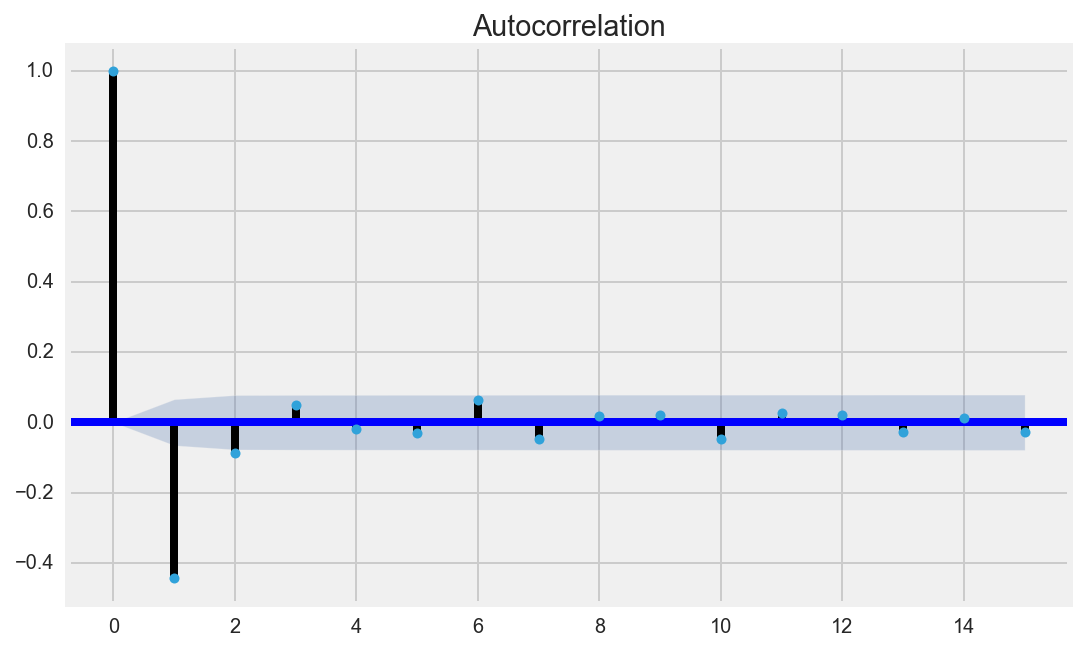

In [363]:
fig = plt.figure(figsize=(8,5))
ax = fig.gca()
plot_acf(avgkwh_diff1, lags=15, ax=ax)
plt.show()

In [364]:
ar4 = ARMA(avgkwh_diff1.values, (1,0)).fit()

In [365]:
ar4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                  894
Model:                     ARMA(1, 0)   Log Likelihood               -8781.643
Method:                       css-mle   S.D. of innovations           4464.026
Date:                Thu, 29 Sep 2016   AIC                          17569.287
Time:                        21:40:44   BIC                          17583.674
Sample:                             0   HQIC                         17574.785
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const         -0.1611    103.455     -0.002      0.999      -202.930   202.608
ar.L1.y       -0.4436      0.030    -14.814      0.000        -0.502    -0.385
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -2.2542           +0.0000j            2.2542            0.5000
-----------------------------------------------------------------------------
"""

In [366]:
r2_score(avgkwh_diff1, ar4.fittedvalues)

0.19713815724462613

The score is reasonable,more believable that the scores above. 

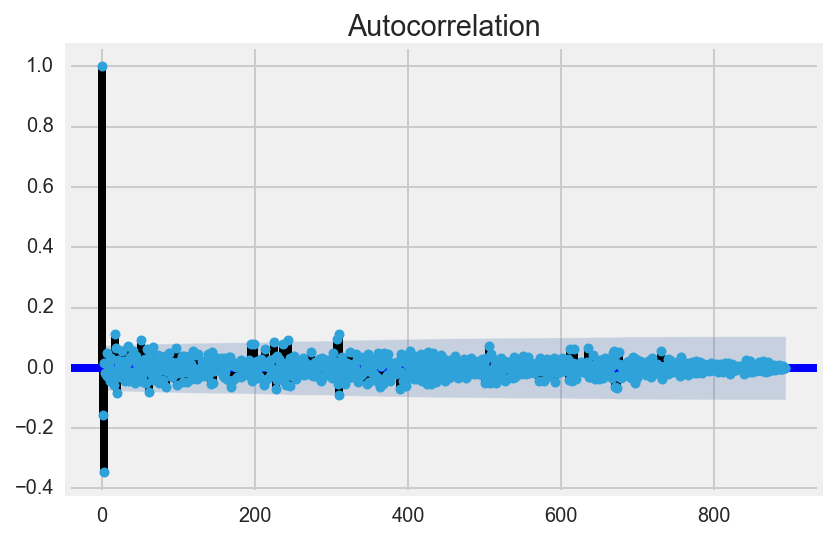

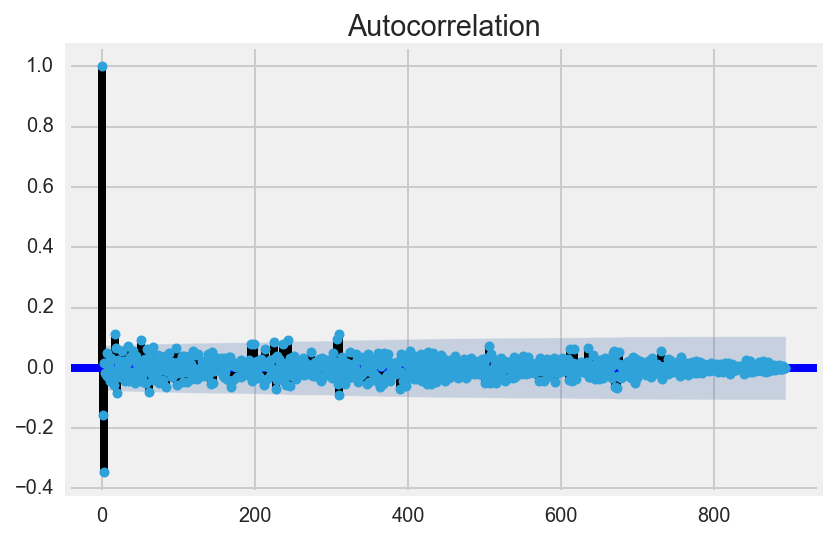

In [367]:
plot_acf(ar4.resid)

Likewise, the auto-correlation plot seems OK. 

<h2> 5.8 Now a solar data time series data in the mixed table. </h2>

In [368]:
nameplate_diff  = pge_q_num.nameplate.diff()

In [369]:
nameplate_diff.dropna(inplace=True)

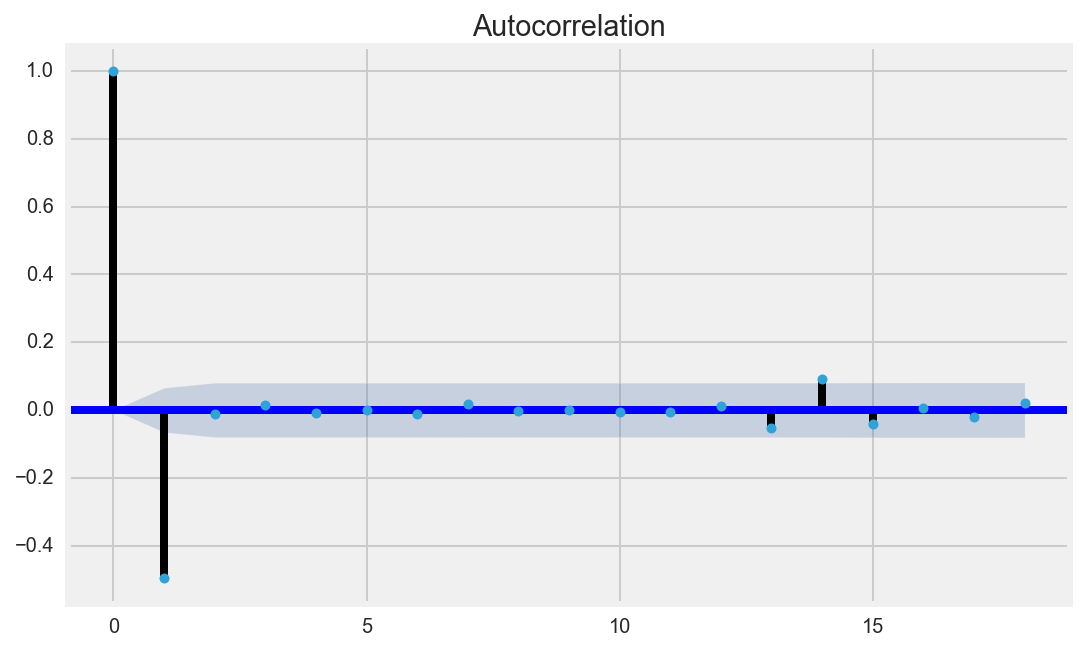

In [370]:
fig = plt.figure(figsize=(8,5))
ax = fig.gca()
plot_acf(nameplate_diff, lags=18, ax=ax)
plt.show()

In [371]:
ar5 = ARMA(nameplate_diff.values, (1,0)).fit()
ar5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                  894
Model:                     ARMA(1, 0)   Log Likelihood               -5554.372
Method:                       css-mle   S.D. of innovations            120.765
Date:                Thu, 29 Sep 2016   AIC                          11114.745
Time:                        21:45:10   BIC                          11129.132
Sample:                             0   HQIC                         11120.243
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const         -0.0017      2.701     -0.001      0.999        -5.295     5.292
ar.L1.y       -0.4960      0.029    -17.101      0.000        -0.553    -0.439
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -2.0161           +0.0000j            2.0161            0.5000
-----------------------------------------------------------------------------
"""

In [372]:
r2_score(nameplate_diff, ar5.fittedvalues)

0.24656957925015521

r2 score is pretty reasonable.

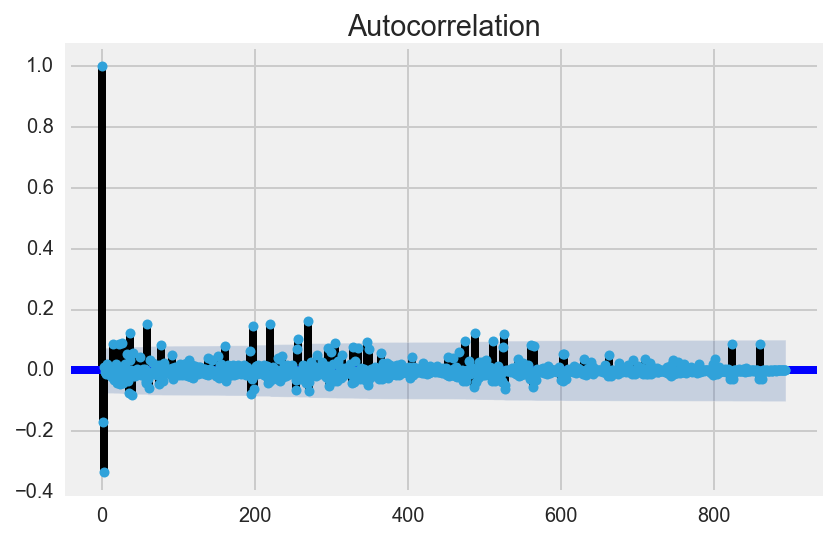

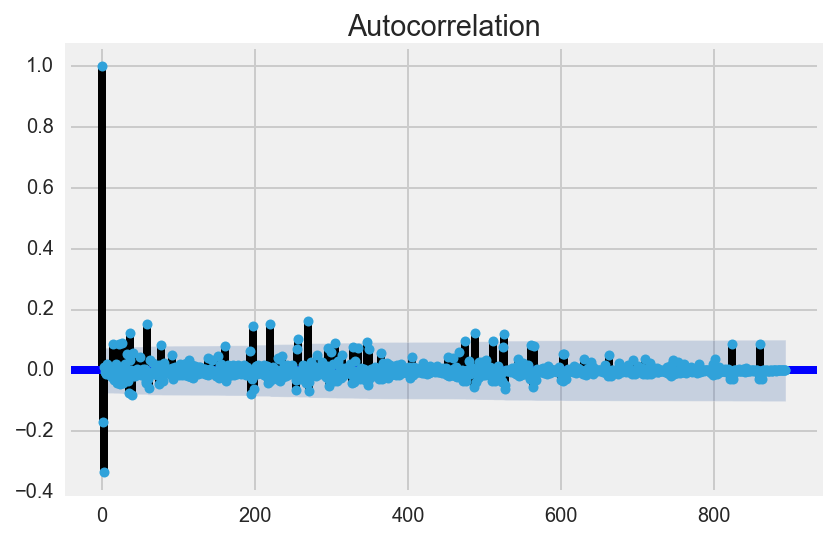

In [373]:
plot_acf(ar5.resid)

The auto-correlation plots look Ok also. No hidden auto-correlations.

In [189]:
pge_q_num.head(3)

,ZipCode,Month,Year,CustomerClass,Combined,TotalCustomers,TotalkWh,AveragekWh,zone,avg_temp
4011,95329,2,2012,2,1,1047.0,654735.0,625.0,12.0,57.166667
6132,94572,6,2016,2,1,2741.0,1359822.0,496.0,3.0,55.000000
2977,93906,2,2012,1,1,503.0,3957274.0,7867.0,3.0,55.000000


<h2> 6. Analysis. </h2>

<h3> 6.1 PGE data analysis </h3>

Regarding the PGE data, it seems that 'TotalkWh' correlates with "zone" and "avg_temp" 
and anti-correlates with "Month", and "CustomerClass". The correlation seems surprising as average temperature 
is concerned, somewhat surprising regarding zones. I would not expect consumption to go up with temperature.
Maybe some of the electricity is used for cooling in hotter zones. Zones 10-16 are more in the desert region of CA. 


Regarding the anti-correlation between TotalkWh and Months, that seems reasonable: as decrease (go from Jun=6 to Jan=1) comsumption increases. There is more consumption in the winter, when is colder. 

There also seems to be some anti-correlation between different CustomerClasses and TotalkWh. The categories are:
Electric-Commercial'=1; 'Electric-Residential'=2; 'Electric-Agricultural'=3;'Electric-Industrial'=4.
Anti-correlation betweek TotalkWh and CustomerClass means that TotalkWh increases as CustomerClass is decreases, so
it is ore for Electric-Commercial and Electric-Residential. So it seems these 2 Customer classes consume more electricity. 



<h3> 6.2 Solar data analysis </h3>

Regarding solar data, I need more detail data, by month for instance. For CSI_Rating, we have correlation w Nameplate_Rating, CEC_PTC_Rating* , CSI Rating*, zone, and anti-correlation w CEC_PTC rating single axis.
The correlation between Nameplate numbers and CEC* , CSI* numbers make sense, they are kWhs from different types
of panels in similar area. The interesting correlation is between Nameplate Rating and zones. The higher number zones,
like 10-16 are more in the desert part of CA. There, we would expect more sun, hence more electricity from solar panels. 

It is not clear why there is the anti-correlation w CEC_PTC_rating single axis. 

<h3> 6.3 Join PG&E and solar data analysis. </h3>

When our target is 'AveragekWh, and it correlates w 'CustomerClass, and correlates w 'zone', 'nameplate',
and 'avg_temp'. The correlation between AveragekWh and Nameplate, avg_temp(average temperature) makes sense: 
as Nameplate numbers, avg_temp increase, so do AveragekWh. 

The correlation beween AveragekWh and zones is interesting: as zones increase, the location is desert-like. There we expect more sunshine, hence more kWh used (perhaps cooling?!) 

The correlation between AveragekWh and CustomerClass is also intereting: as  in the PG&E data analysis, the higher CustomerClass numbers correspond to Electric-Agricultural and Electric-Industrial. These seem the bigger consumers of
electricity. 

If we switch to 'TotalkWh', we get correlation w 'CustomerClass[3]',  'csi', 'avg_temp', 
'zone' and 'cec'.

The correlation between TotalkWh and CSI*, avg_temp and CEC* is interesting: the more TotalkWh used, more solar power is generated by solar panels. So maybe people we switching to more solar power generation. 

The correlation between TotalkWh and avg_temp and zone is reasonable: higher temperature, higher use of electricity (maybe cooling, as above); and higher zones are in the desert, correlating with higher temperature. 

The last correlation, between TotalkWh and CustomerClass[3], Electric-Agricultural is interesting. Perhaps agricultural users need more electricity than other customers. 

<h2> Conclusion. </h2>

A data science project is a bit like making a documentary: we gather data, explore it, analyse it. At the end, 
we hope to find an interesting story to tell. Hopefully this was an interesting story. 